# Here be dragons: exploring the stellar mass-halo mass relation in the dwarf regime with EMERGE...the notebook!
##### About:
This notebook is intended to provide the scripts necessary to reproduce the key results shown [UPDATE](https://ui.adsabs.harvard.edu/abs/2020arXiv200102687O/abstract). I omit plots that include data and results of other works.

##### Data:
The data necessary to reproduce these results can be found [here](http://www.usm.uni-muenchen.de/emerge/data/galtrees/hdf5/). This data is produced using the code [EMERGE](http://www.usm.uni-muenchen.de/emerge/)

##### Code:
To run this notebook you will also need to install my personal library of analysis tools [galaxybox](https://github.com/jaoleary/galaxybox). If there are questions regarding the usage of these tools please consult that repository directly...or contact me.

##### Discalimer:
This notebook relies on publicly available data and codes, I cannot gurantee that updates to either of this won't result in a change to the results shown in this notebook or the associated paper. If for some reason you are unable to run this notebook or if you find some error **please** contact me.

# RUN THESE CELLS FIRST

## IMPORT LIBRARIES

In [1]:
from galaxybox import sim_managers as gb
from galaxybox.plot.plot import ls # some extra linestyle options

# Standard imports
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import subprocess
import h5py
import os
from sys import version
import glob
import yaml

# Astropy imports
from astropy import cosmology as apcos
import astropy.units as apunits
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from halotools.mock_observables import radial_distance
from astropy.convolution import convolve
from astropy.convolution.kernels import Gaussian1DKernel
from astropy.convolution.kernels import Gaussian2DKernel

# Scipy imports
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.stats import kde

# plotting
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
from matplotlib import container
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import seaborn as sns

from IPython.display import display, Math


### package versions

In [66]:
# export my conda environment config to yml file.
with open(os.path.abspath('code-configs/environment.yml'), 'w') as fp:
    subprocess.call(['conda', 'env', 'export'], stdout=fp)

In [57]:
# I'm using galaxybox in dev mode. Print the current git-hash and system to build.yml

encoding='utf-8'
path = '/home/joleary/Programs/galaxybox'

with open('code-configs/build.yml', 'r') as stream:
    build = yaml.safe_load(stream)

args = ['git', 'describe', '--dirty', '--always', '--tags']
process = subprocess.Popen(args, stdout=subprocess.PIPE, cwd=path)
build['Code']['Galaxybox']['git-hash'] = process.stdout.read().decode(encoding).strip()
args = ['hostname']
process = subprocess.Popen(args, stdout=subprocess.PIPE, cwd=path)
build['Code']['Galaxybox']['system'] = process.stdout.read().decode(encoding).strip()

with open('code-configs/build.yml', 'w') as stream:
    yaml.dump(build, stream)

## PLOTTING DEFAULTS

In [4]:
plt.rcParams.update({'axes.linewidth' : 2,
                     'xtick.labelsize' : 16,
                     'xtick.major.width' : 2,
                     'xtick.major.size'  : 6,
                     'xtick.minor.width'  : 1,
                     'xtick.minor.size'  : 3,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.labelsize' : 16,
                     'ytick.major.width' : 2,
                     'ytick.major.size'  : 6,
                     'ytick.minor.width'  : 1,
                     'ytick.minor.size'  : 3,
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'font.family':'serif',
                     'mathtext.fontset': 'cm',
                     'figure.facecolor' : 'white'})

## IMPORT DATA

In [36]:
DATA_DIR = '/scratch/users/joleary/dwarves'
P60 = gb.Universe(param_path = os.path.join(DATA_DIR, 'parameterfiles/Royale.param'), sim_type = 'emerge')
P60_inst = gb.Universe(param_path = os.path.join(DATA_DIR, 'parameterfiles/Royale_inst.param'), sim_type = 'emerge')
P60_linmax = gb.Universe(param_path = os.path.join(DATA_DIR, 'parameterfiles/Royale_linmax.param'), sim_type = 'emerge')
P60_logistic = gb.Universe(param_path = os.path.join(DATA_DIR, 'parameterfiles/Royale_logistic.param'), sim_type = 'emerge')

models = [P60, P60_inst, P60_linmax, P60_logistic]
for m in models:
    m.params.update('OutputDir', value=DATA_DIR)
    m.add_galaxy_catalog()
    # trees are big, so just do limited import to get some star formation history
    m.add_galaxy_trees(fields_out=['ID', 'Scale', 'Desc_ID', 'MMP_ID', 'Leaf_ID', 'Stellar_mass', 'Halo_mass', 'SFR', 'Scale_peak_mass', 'Mean_age', 'Type'])
    m.galaxy_trees.sort_index()
    m.add_statistics()
    m.add_fits()
    m.add_figdir(os.path.abspath('./Figures/'))

Loading galaxy lists:


Loading galaxy trees:   0%|          | 0/64 [00:00<?, ?it/s]

Loading statistics:
/scratch/users/joleary/dwarves/Royale/statistics.h5
Loading galaxy lists:


Loading galaxy trees:   0%|          | 0/64 [00:00<?, ?it/s]

Loading statistics:
/scratch/users/joleary/dwarves/Royale_inst/statistics.h5
Loading galaxy lists:


Loading galaxy trees:   0%|          | 0/64 [00:00<?, ?it/s]

Loading statistics:
/scratch/users/joleary/dwarves/Royale_linmax/statistics.h5
Loading galaxy lists:


Loading galaxy trees:   0%|          | 0/64 [00:00<?, ?it/s]

Loading statistics:
/scratch/users/joleary/dwarves/Royale_logistic/statistics.h5


In [19]:
# Load local group data
LG = pd.read_csv('./local_group.dat',index_col=0, skipinitialspace=True, na_values='-')

# Section 4: Results

## Section 4.1: Model Selection

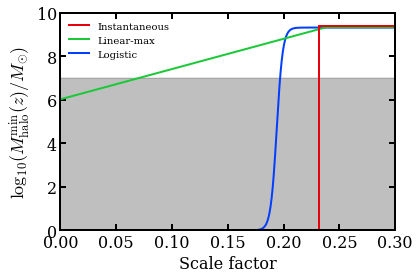

In [50]:
# define each quenching model
def logistic(x, x0=0.5, k=-1, L=1):
    return L / (1+np.exp(-(10**(k))*(x-x0)))
def linear(x, m=1, b=1):
    return m*x + b
def linear_max(x,m=1,ymax=1,xmax=1):
    m = 10**m
    x = np.atleast_1d(x)
    y = m*(x-xmax)+ymax
    mask = (y >= ymax)
    y[mask] = ymax
    return y


x = np.linspace(0,1,1000)
miny, maxy = 0, 10
minx, maxx = 0, 0.3
fig, ax = plt.subplots()
ax.set_ylim([miny,maxy])
ax.set_xlim([minx,maxx])
ax.set_xlabel('Scale factor', size= 16)
ax.set_ylabel('$\log_{10}(M^{\mathrm{min}}_{\mathrm{halo}}(z)/M_{\odot})$', size=18)

# plot logistic model
xm, y, k = P60_logistic.params.get_param('Reionization_Scale'), P60_logistic.params.get_param('Reionization_Mass'), P60_logistic.params.get_param('Reionization_Rate')
ax.plot(x,logistic(x, x0=xm, k=k, L=y), color=sns.color_palette('bright')[0], lw=2)

# plot lin-max model
xm, y, k = P60_linmax.params.get_param('Reionization_Scale'), P60_linmax.params.get_param('Reionization_Mass'), P60_linmax.params.get_param('Reionization_Rate')
ax.plot(x,linear_max(x, m=k, ymax=y, xmax=xm), ls='-', color=sns.color_palette('bright')[2], lw=2)

# plot instantaneous model
xm, y = P60_inst.params.get_param('Reionization_Scale'), P60_inst.params.get_param('Reionization_Mass')
ax.axvline(x=xm, ymin=0, ymax=(y-miny)/(maxy-miny), color=sns.color_palette('bright')[3], lw=2)
ax.axhline(y=y, xmin=xm/(maxx-minx), xmax=1, color=sns.color_palette('bright')[3], lw=2)

# plot resolution limit
ax.fill_between(x,np.zeros(len(x))+7, np.zeros(len(x)), alpha=0.25, color='k')

handles = [Line2D([0], [0], color=sns.color_palette('bright')[3], lw=2, ls='-', label='Instantaneous')]
handles += [Line2D([0], [0], color=sns.color_palette('bright')[2], lw=2, ls='-', label='Linear-max')]
handles += [Line2D([0], [0], color=sns.color_palette('bright')[0], lw=2, ls='-', label='Logistic')]
ax.legend(handles=handles, frameon=False)

#P60.savefig('mod_compare.pdf')
plt.show()

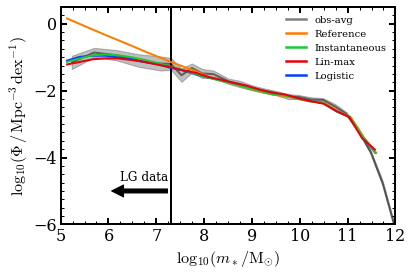

In [56]:
smf = np.loadtxt('./smf.dat', skiprows=1, delimiter=',')

fig,ax = plt.subplots()
ax.set_xlabel('$\log_{10}(m_* / \mathrm{M}_{\odot})$', size=16)
ax.set_ylabel('$\log_{10}(\Phi \, / \, \mathrm{Mpc}^{-3}\,\mathrm{dex}^{-1})$', size=16)
ax.set_xlim([5,12])
ax.set_ylim([-6,0.5])
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(5,13,1)))
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,13,0.25)))
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-6,1,0.25)))

model_label = [ 'Logistic', 'Reference', 'Instantaneous', 'Lin-max']
model_color = sns.color_palette('bright')
models = [P60_logistic, P60, P60_inst, P60_linmax]

# plot smf for each model
for i, m in enumerate(models):
    galaxies = m.galaxy.list(min_mstar=5)
    Lbox = m.params.get_param('BoxSize') / m.cosmology.h
    vol = (Lbox**3)

    N, edges = np.histogram(galaxies['Stellar_mass'].values, bins=25)
    centers = (edges[:-1] + edges[1:]) / 2
    db = (edges[1] - edges[0])
    
    ax.plot(centers, np.log10(N / db / vol), color=model_color[i], lw=2, label=model_label[i],zorder=10)

# plot observed data   
ax.plot(smf[:,0],smf[:,1], label='obs-avg', lw = 2, color = 'black', alpha=0.5)
ax.fill_between(smf[:,0], smf[:,2], smf[:,3], color='black', alpha=0.25,zorder=0)

# set legend
color = sns.color_palette('bright')
handles = [Line2D([0], [0], color='k', lw=2.5, alpha=0.5, label='obs-avg'),
           Line2D([0], [0], color=model_color[1], lw=2.5, label='Reference'),
           Line2D([0], [0], color=model_color[2], lw=2.5, label='Instantaneous'),
           Line2D([0], [0], color=model_color[3], lw=2.5, label='Lin-max'),
           Line2D([0], [0], color=model_color[0], lw=2.5, label='Logistic')]
ax.legend(handles = handles, frameon=False)

# annotations to shown range of local group data
ax.axvline(x=7.3, ymin=-7, ymax=1, color='black', lw=2)
ax.annotate('', xy=(6, -5),  xycoords='data',
            xytext=(7.3, -5), textcoords='data',
            arrowprops=dict(facecolor='black', edgecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom',
            )
ax.annotate('LG data', xy=(7.25, -4.8), xycoords='data', size=12, ha='right', va='bottom')
#P60.savefig('global_smf.pdf', bbox_inches='tight')
plt.show()

## Section 4.2: Stellar-to-Halo mass relation

### SHMR

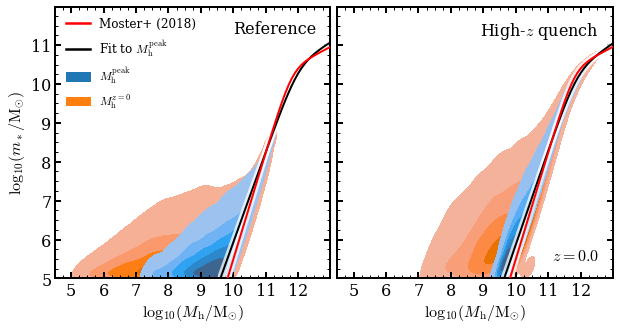

In [47]:
def log_efficiency(M, M1, eps_N, beta, gamma):
    return np.log10(2*eps_N)-np.log10((10**(M-M1))**(-beta) + (10**(M-M1))**gamma)

def double_power(x, a, b, c, d):
    return x+b-np.log10((10.**(x-a))**(-c)+(10.**(x-a))**(d))

# setup the data
vmin, vmax = -12.5, -8.9 
mh_min, mh_max, bin_size = 10, 13.7, 0.2
mbin=np.arange(mh_min,mh_max,bin_size)
redshift=0
#galaxies = model.galaxy.list(z=redshift, min_mstar=5) # select only type 0 galaxies
f_baryon = P60.cosmology.Ob0 / P60.cosmology.Om0

mbin=np.arange(mh_min,mh_max,bin_size)

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_ylim([5,11.99])
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[0].set_ylabel('$\log_{10}(m_*/\mathrm{M}_{\odot})$',size = 16)
ax[0].set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M^{z=0}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[0].set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

#for i, axi in enumerate(ax.reshape(-1)):
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[0].xaxis.set_ticks(np.arange(4,15))
ax[0].set_xlim([4.5,12.99])

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[1].xaxis.set_ticks(np.arange(4,15))
ax[1].set_xlim([4.5,12.99])

# Reference model
glist = P60.galaxy.list(z=redshift, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[0], levels=6, fill=True)
sns.kdeplot(data=glist, x='Halo_mass', y="Stellar_mass", ax=ax[0], levels=6, fill=True, zorder=0)
# fit double power law
mhalo,_,_ = binned_statistic(glist['Halo_mass_peak'], glist['Halo_mass_peak'], statistic='mean',bins=mbin)
mstar,_,_= binned_statistic(glist['Halo_mass_peak'], glist['Stellar_mass'], statistic='mean',bins=mbin)
popt, pcov = curve_fit(double_power, mhalo, mstar,p0=[10,1,1,1],maxfev=10000)
# plot
ax[0].plot(x,double_power(x,*popt),color='black',lw=2,zorder=10)
ax[0].plot(x,double_power(x,*popt),color='white',lw=7,alpha=0.75)
ax[0].annotate('Reference', xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=16, ha='right', va='top',color='k')

# logistic
glist = P60_logistic.galaxy.list(z=redshift, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[1], levels=6, fill=True)
sns.kdeplot(data=glist, x='Halo_mass', y="Stellar_mass", ax=ax[1], levels=6, fill=True,zorder=0)
# fit double power law
mhalo,_,_ = binned_statistic(glist['Halo_mass_peak'], glist['Halo_mass_peak'], statistic='mean',bins=mbin)
mstar,_,_= binned_statistic(glist['Halo_mass_peak'], glist['Stellar_mass'], statistic='mean',bins=mbin)
popt, pcov = curve_fit(double_power, mhalo, mstar,p0=[10,1,1,1],maxfev=10000)
# plot
ax[1].plot(x,double_power(x,*popt),color='black',lw=2,zorder=10)
ax[1].plot(x,double_power(x,*popt),color='white',lw=7,alpha=0.75)
ax[1].annotate('High-$z$ quench', xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=16, ha='right', va='top',color='k')

# moster 2018
x = np.arange(9,15,0.1)
old = np.array([11.80, 0.14, 1.75, 0.57]) # parameters from moster 2018
ax[0].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='r',lw=2,zorder=10, label='Moster+ (2018)')
ax[0].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='white',lw=7,alpha=0.75)
ax[1].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='r',lw=2,zorder=10, label='Moster+ (2018)')
ax[1].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='white',lw=7,alpha=0.75)

ax[1].annotate('$z={:.1f}$'.format(redshift), xy=(1-0.05, 0.05), xycoords='axes fraction', size=16, ha='right', va='bottom')

handles = [Line2D([0], [0], color='r', lw=2.5, ls='-', label='Moster+ (2018)'),
           Line2D([0], [0], color='k', lw=2.5, ls='-', label='Fit to $M^{\mathrm{peak}}_{\mathrm{h}}$'),
           patches.Patch(color=sns.color_palette()[0], label='$M^{\mathrm{peak}}_{\mathrm{h}}$'),
           patches.Patch(color=sns.color_palette()[1], label='$M^{z=0}_{\mathrm{h}}$') ]
ax[0].legend(handles=handles, frameon=False, fontsize=12)
#P60.savefig('SHMR_split.pdf', bbox_inches='tight')

### Scatter in SHMR

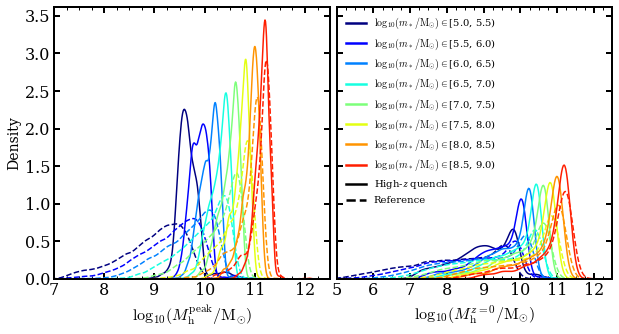

In [49]:
from scipy.stats import kde
def color(n, tot):
    return plt.cm.jet(n / tot, 1)

mbin = np.arange(5,9.5,0.5)
percentile=68 

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.025)
#ax[0].set_ylim([5,11.99])
#ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
#ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[0].set_ylabel('Density', size = 14)
ax[0].set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M^{z=0}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

#for i, axi in enumerate(ax.reshape(-1)):
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(7, 14.5+1, 0.25)))
ax[0].xaxis.set_ticks(np.arange(7,15))
ax[0].set_xlim([7,12.49])

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[1].xaxis.set_ticks(np.arange(4,15))
ax[1].set_xlim([5,12.49])

handles = []
models = [P60, P60_logistic]
ls = ['--', '-']
md = ['_peak', '']
for i in range(len(mbin)-1):
    txt = '$\in [{:.1f}, {:.1f})$ '.format(mbin[i], mbin[i+1])
    
    for j, m in enumerate(models):
        glist = m.galaxy.list(z=redshift, min_mstar=mbin[i], max_mstar=mbin[i+1])
        N = len(glist)
        of = (glist.Type==2).sum()/N
        txt += '& ${:d}$ & ${:.2f}$ '.format(N, of)
        for d, axi in enumerate(ax.reshape(-1)):
            sns.kdeplot(glist['Halo_mass'+md[d]].values, color=color(i, len(mbin)-1), ax=ax[d], ls=ls[j])

            k = kde.gaussian_kde(glist['Halo_mass'+md[d]].values)
            x = np.linspace(4,12,1000)
            y = k.evaluate(x)
            #peak, _ = find_peaks(y, height=0.5*y.max())
            peak = np.argmax(y)
            n=0
            mask = y > y[peak]*(0.95-n*0.01)
            while k.integrate_box_1d(x[mask][0], x[mask][-1]) < 0.68:
                n+=1
                mask = y > y[peak]*(0.98-n*0.01)

            q  = np.abs(x[mask][[0,-1]] - x[peak])

            s = '& ${0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}$ '
            txt += s.format(x[peak], q[0], q[1])

    label = '$\log_{10}(m_*/\mathrm{M}_{\odot}) \in$' + '[{:.1f}, {:.1f})'.format(mbin[i], mbin[i+1])
    handles += [Line2D([0], [0], color=color(i, len(mbin)-1), lw=2.5, ls='-', label=label)]
    txt += '\\\\'
    #print(txt)

handles += [Line2D([0], [0], color='k', lw=2.5, ls='-', label='High-$z$ quench'),
            Line2D([0], [0], color='k', lw=2.5, ls='--', label='Reference')]
ax[1].legend(handles=handles, frameon=False)
#P60.savefig('SHMR_scatter_joint.pdf', bbox_inches='tight')

## Section 4.3: Satellite populations

### sat smf

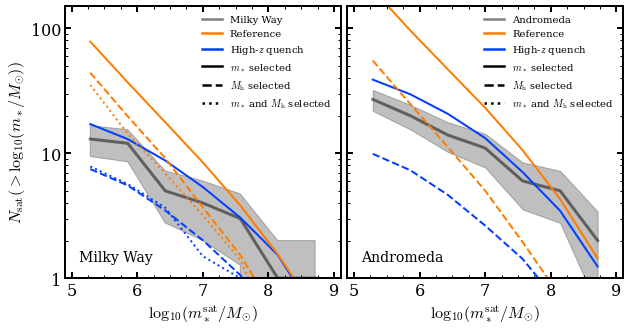

In [39]:
MW_sats = LG.loc[LG.D_MW < 300]
M31_sats = LG.loc[LG.D_M31 < 300]

model_label = ['High-$z$ quench', 'Reference']
model_color = ['blue', 'green']
model_color = sns.color_palette('bright')
ls = ['-', '--', ':']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]
models = [P60_logistic, P60]
mvir_range = [(np.log10(1e12), np.log10(2e12)),
              (np.log10(1.4e12), np.log10(5e12))]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_yscale('log')
ax[0].set_ylim([1,150])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax[0].set_ylabel('$N_{\mathrm{sat}}(>\log_{10}(m_*/M_{\odot}))$',size=16)

# plot obsered sat smf.
bins = np.histogram_bin_edges([5,9],bins=7)
hist, edges = np.histogram(MW_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[0].plot(mid, N, lw=3, color='black', label='Milky Way', alpha=0.5)
ax[0].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)

hist, edges = np.histogram(M31_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[1].plot(mid, N, lw=3, color='black', label='Andromeda', alpha=0.5)
ax[1].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)

# cases are the stellar/halo mass ranges used for the MW and M31 respectively
cases = [((10.6, 10.78, 0, np.inf),
         (5, np.inf, 12.0, 12.2),
         (10.6, 10.78, 12.0, 12.2)),
         ((10.93, 11.1, 0, np.inf),
         (5, np.inf, 12.15, 12.3),
         (10.93, 11.1, 12.15, 12.3))]

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    min_mvir, max_mvir = mvir_range[i]
    axi.set_xlabel('$\log_{10}(m_*^{\mathrm{sat}}/M_{\odot})$', size=16)
    axi.set_xlim([4.9,9.1])
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,10,0.25)))

    case = cases[i]
    for j, m in enumerate(models):
        for k, c in enumerate(case): 
            min_mstar, max_mstar, min_mvir, max_mvir = c
            # find all hosts that fit criteria
            hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0, min_mvir=min_mvir, max_mvir=max_mvir)
            Ntot = np.zeros(len(edges)-1)
            # loop over hosts
            for index, row in hosts.iterrows():
                # collect all satellites of that host and add to the hist.
                sats = m.galaxy.list(ihost=index, min_mstar=5)
                hist, _ = np.histogram(sats['Stellar_mass'].values, bins=bins)
                N = hist[::-1].cumsum()[::-1]

                Ntot += N
            axi.plot(mid, Ntot/len(hosts), lw=2, color=model_color[j], ls=ls[k])

# first legend 
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Milky Way', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls=':', label='$m_*$ and $M_{\\mathrm{h}}$ selected')]
ax[0].legend(handles=handles, loc='upper right', frameon=False)

# second legend
handles[0] = Line2D([0], [0], color='black', lw=2.5, ls='-', label='Andromeda', alpha=0.5)
ax[1].legend(handles=handles, loc='upper right', frameon=False)

ax[0].annotate('Milky Way', xy=(0.05, 0.05), xycoords='axes fraction', size=14, ha='left', va='bottom')
ax[1].annotate('Andromeda', xy=(0.05, 0.05), xycoords='axes fraction', size=14, ha='left', va='bottom')

#P60.savefig('cumulative_sat_smf.pdf', bbox_inches='tight')
plt.show()

### sat distribution

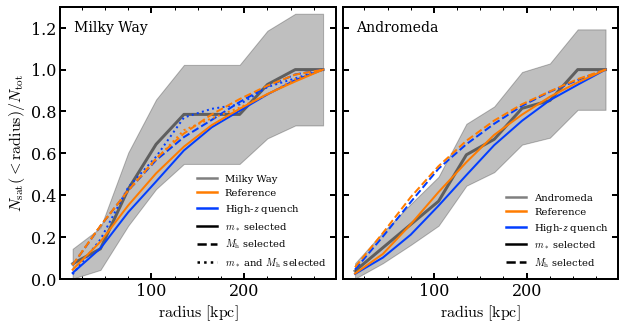

In [41]:
MW_sats = LG.loc[LG.D_MW < 300]
M31_sats = LG.loc[LG.D_M31 < 300]

model_label = ['Logistic', 'Reference']
model_color = ['blue', 'green']
model_color = sns.color_palette('bright')
ls = ['-', '--', ':']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]
models = [P60_logistic, P60]
mvir_range = [(np.log10(1e12), np.log10(2e12)),
              (np.log10(1.4e12), np.log10(5e12))]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_ylim([0,1.3])
ax[0].set_ylabel('$N_{\mathrm{sat}}(<\mathrm{radius})/N_{\\mathrm{tot}}$',size=16)

# plot obsered sat dist.
bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(MW_sats['D_MW'], bins=bins)
N = hist.cumsum()
mid = (bins[1:] + bins[:-1])/2
ax[0].plot(mid, N/N[-1], lw=3, color='black', label='Milky Way', alpha=0.5)
ax[0].fill_between(mid, (N+np.sqrt(N))/N[-1], (N-np.sqrt(N))/N[-1], color='black', alpha=0.25)

bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(M31_sats['D_M31'], bins=bins)
N = hist.cumsum()
ax[1].plot(mid, N/N[-1], lw=3, color='black', label='Andromeda', alpha=0.5)
ax[1].fill_between(mid, (N+np.sqrt(N))/N[-1], (N-np.sqrt(N))/N[-1], color='black', alpha=0.25)

# cases are the stellar/halo mass ranges used for the MW and M31 respectively
cases = [((10.6, 10.78, 0, np.inf),
         (5, np.inf, 12.0, 12.2),
         (10.6, 10.78, 12.0, 12.2)),
         ((10.93, 11.1, 0, np.inf),
         (5, np.inf, 12.15, 12.3),
         (10.93, 11.1, 12.15, 12.3))]

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    min_mvir, max_mvir = mvir_range[i]
    axi.set_xlabel('$\mathrm{radius\,\,[kpc]}$',size=16)
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,500,25)))

    case = cases[i]
    for j, m in enumerate(models):
        for k, c in enumerate(case):
            Ntot = np.zeros(len(bins)-1)
            min_mstar, max_mstar, min_mvir, max_mvir = c
            # find all hosts that fit criteria
            hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0, min_mvir=min_mvir, max_mvir=max_mvir)
            # loop over hosts
            for index, row in hosts.iterrows():
                # collect all satellites of that host and add to the hist.
                sats = m.galaxy.list(ihost=index, min_mstar=5)
                pos = sats[['X_pos','Y_pos','Z_pos']].values
                xs, ys, zs = pos[:,0], pos[:,1], pos[:,2]

                x,y,z = row[['X_pos','Y_pos','Z_pos']].values
                xc, yc, zc = [x]*len(pos), [y]*len(pos), [z]*len(pos)
                r_sat = radial_distance(xs, ys, zs, xc, yc, zc, period=m.params.get_param('BoxSize')/m.cosmology.h)
                hist, _ = np.histogram(r_sat*1000, bins=bins)
                N = hist.cumsum()
                Ntot += N
                Nmax = Ntot[-1]/len(hosts)
            axi.plot(mid, Ntot/len(hosts)/Nmax, lw=2, color=model_color[j], ls=ls[k])

# first legend
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Milky Way', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls=':', label='$m_*$ and $M_{\\mathrm{h}}$ selected')]
ax[0].legend(handles=handles, loc='lower right', frameon=False)

# second legend
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Andromeda', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected')]
ax[1].legend(handles=handles, loc='lower right', frameon=False)

ax[0].annotate('Milky Way', xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
ax[1].annotate('Andromeda', xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
#P60.savefig('cumulative_sat_smf_normed.pdf', bbox_inches='tight')
plt.show()

## Section 4.4: Star formation history

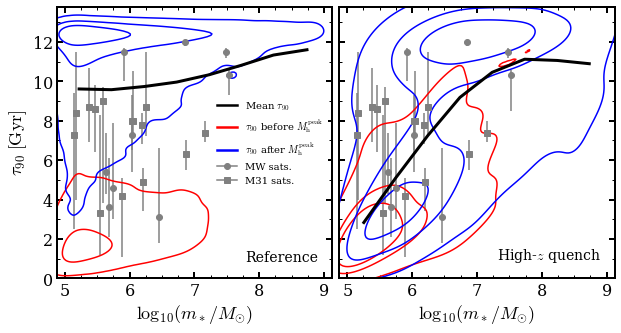

In [37]:
MW_sats = LG.loc[LG.D_MW < 300]
M31_sats = LG.loc[LG.D_M31 < 300]

mbin=np.arange(5,15,0.5)
min_mstar, max_mstar = 5, 9
stat = 'mean'
frac = 0.9
gtype = [1,2]

model_label = ['Reference', 'High-$z$ quench']
model_color = ['black', 'red', 'blue', 'green']
colors = ["#FF0B04", "#4374B3"]
colors = ["red", "blue"]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)

ax[0].set_ylabel(r'$\tau_{90}\;[\mathrm{Gyr}]$', size=18)
ax[0].set_ylim([0, models[0].cosmology.age(0).value])
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,14,1)))

models = [P60, P60_logistic]
model_label = ['Reference', 'High-$z$ quench']
colors = ["red", "blue"]

for i, axi in enumerate(ax.reshape(-1)):
    axi.set_xlim([4.875,9.125])
    axi.set_xlabel('$\log_{10}(m_*/M_{\odot})$', size=18)
    axi.xaxis.set_major_locator(ticker.FixedLocator(np.arange(5,13,1)))
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,13,0.25)))
    
    axi.errorbar(MW_sats['StellarMass'].values, MW_sats['t90'].values, yerr = np.abs(MW_sats[['t90_down', 't90_up']].values.astype(float).T), ls='', marker='o', color='grey')
    axi.errorbar(M31_sats['StellarMass'].values, M31_sats['t90'].values, yerr = np.abs(M31_sats[['t90_down', 't90_up']].values.astype(float).T), ls='', marker='s', color='grey')
    axi.annotate(model_label[i], xy=(1-0.05, 0.05), xycoords='axes fraction', size=14, ha='right', va='bottom',color='k')
    
    m = models[i]
    ihost = m.galaxy.list(min_mstar=10.5, max_mstar=11.2).index.values
    igal = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=gtype, ihost=ihost).index.values
    s = m.galaxy_trees.scale_at_massfrac(igal, frac=frac, interpolate=False)
    mstar = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar,gtype=gtype, ihost=ihost)['Stellar_mass'].values
    mgal,_,_ = binned_statistic(mstar, mstar, statistic=stat, bins=mbin)
    fr,_,_ = binned_statistic(mstar, m.cosmology.age(1/s-1), statistic=stat, bins=mbin)
    axi.plot(mgal, fr, lw=3, color='black')
    mask = s - m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=gtype, ihost=ihost)['Scale_peak_mass'].values > 0
    data = {'mass': mstar,
            'age': m.cosmology.age(1/s-1).value,
            'mask': mask}

    with sns.color_palette(colors):
        sns.kdeplot(data=data, x='mass', y='age', ax=axi, hue='mask', levels=4,common_norm=True,legend=False)

handles = [Line2D([0], [0], color='k', lw=2.5, ls='-', label=r'Mean $\tau_{90}$'),
           Line2D([0], [0], color='r', lw=2.5, ls='-', label=r'$\tau_{90}$ before $M_{\mathrm{h}}^{\mathrm{peak}}$'),
           Line2D([0], [0], color='b', lw=2.5, ls='-', label=r'$\tau_{90}$ after $M_{\mathrm{h}}^{\mathrm{peak}}$'),
           Line2D([0], [0], color='grey', marker='o', label='MW sats.'),
           Line2D([0], [0], color='grey', marker='s', label='M31 sats.')]
ax[0].legend(handles=handles, loc = 'center right',  edgecolor='white', facecolor='white', framealpha=1)
#P60.savefig('t90_joint.pdf', bbox_inches='tight')

# Scratch

In [645]:
sns.color_palette('bright')[:4]

(0.00784313725490196, 0.24313725490196078, 1.0)

In [174]:
mask = (obs[:,0] > 5.5) & (obs[:,0] <= 7.75)
popt, pcov = curve_fit(line, obs[:,0][mask], obs[:,1][mask])
print(popt[0])

-0.2790933626712456


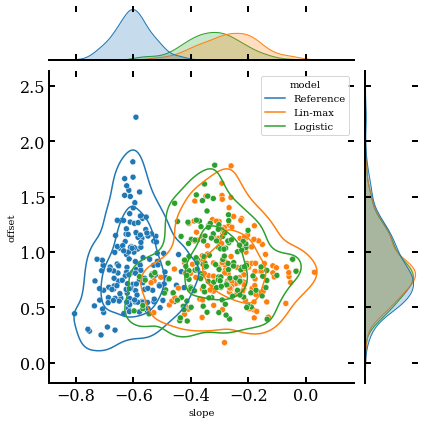

In [233]:
mask = data.model != 'Instantaneous'
g = sns.jointplot(data=data[mask], x="slope", y="offset", hue="model")
g.plot_joint(sns.kdeplot, levels=3)

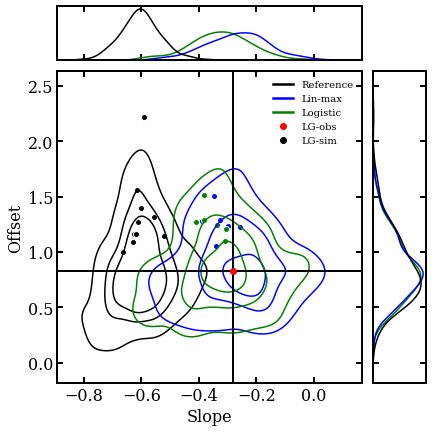

In [271]:
mask = (data.model != 'Instantaneous') 
colors = np.array(model_color)[[0,2,3]]
with sns.color_palette(colors):
#with sns.color_palette('Spectral', n_colors=3):
    g = sns.JointGrid(data=data[mask], x="slope", y="offset", hue="model")
    g.plot_joint(sns.kdeplot, levels=4, legend=False)
    g.plot_marginals(sns.kdeplot)

g.ax_joint.axvline(x=-0.28, ymin=-1, ymax=3, color='black', lw=2)
g.ax_joint.axhline(y=0.83, xmin=-1, xmax=1, color='black', lw=2)
g.ax_joint.axis('on')
for sp in g.ax_joint.spines:
    g.ax_joint.spines[sp].set_visible(True)
    g.ax_marg_x.spines[sp].set_visible(True)
    g.ax_marg_y.spines[sp].set_visible(True)
g.set_axis_labels('Slope','Offset',size=16)

handles = []
for i, m in enumerate(np.array(model_label)[[0,2,3]]):
    mask = (data.model == m) & (data.color=='red')
    d = data.loc[mask].copy()
    g.ax_joint.scatter(d['slope'], d['offset'], color=colors[i], edgecolors='white')
    handles += [Line2D([0], [0], color=colors[i], lw=2.5, ls='-', label=m)]
g.ax_joint.scatter(-0.28, 0.83, marker = 'o', color='red', zorder=10)

handles += [Line2D([0], [0], color='r', lw=0, marker='o', label='LG-obs'),
            Line2D([0], [0], color='k', lw=0, marker='o', label='LG-sim'),]
g.ax_joint.legend(handles=handles, loc = 'upper right', frameon=False)
P60.savefig('normalcy.pdf', bbox_inches='tight')

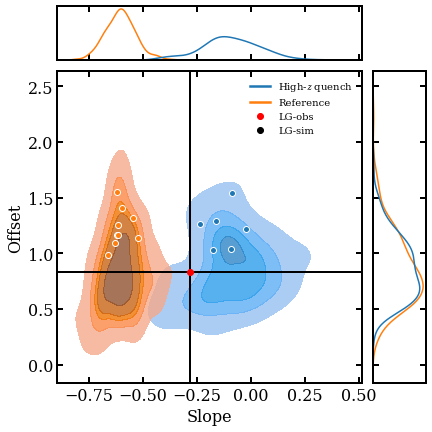

In [20]:
model_label = [ 'Logistic', 'Reference', 'Instantaneous', 'Lin-max']
mask = (data.model != 'Instantaneous') & (data.model != 'Lin-max')
colors = sns.color_palette()[:2]
with sns.color_palette(colors):
#with sns.color_palette('Spectral', n_colors=3):
    g = sns.JointGrid(data=data[mask], x="slope", y="offset", hue="model")
    g.plot_joint(sns.kdeplot, levels=6, legend=False, fill=True, alpha=0.8)
    g.plot_marginals(sns.kdeplot)

g.ax_joint.axvline(x=-0.28, ymin=-1, ymax=3, color='black', lw=2)
g.ax_joint.axhline(y=0.83, xmin=-1, xmax=1, color='black', lw=2)
g.ax_joint.axis('on')
for sp in g.ax_joint.spines:
    g.ax_joint.spines[sp].set_visible(True)
    g.ax_marg_x.spines[sp].set_visible(True)
    g.ax_marg_y.spines[sp].set_visible(True)
g.set_axis_labels('Slope','Offset',size=16)

handles = []
modelL = ['High-$z$ quench', 'Reference']
for i, m in enumerate(np.array(model_label)[[0,1]]):
#for i, m in enumerate(model_label):
    mask = (data.model == m) & (data.color=='red')
    d = data.loc[mask].copy()
    g.ax_joint.scatter(d['slope'], d['offset'], color=colors[i], edgecolors='white')
    handles += [Line2D([0], [0], color=colors[i], lw=2.5, ls='-', label=modelL[i])]
g.ax_joint.scatter(-0.28, 0.83, marker = 'o', color='red', zorder=10)

handles += [Line2D([0], [0], color='r', lw=0, marker='o', label='LG-obs'),
            Line2D([0], [0], color='k', lw=0, marker='o', label='LG-sim'),]
g.ax_joint.legend(handles=handles, loc = 'upper right', frameon=False)
P60.savefig('normalcy.pdf', bbox_inches='tight')

In [13]:
np.array(model_label)[[0,1]]

array(['Logistic', 'Lin-max'], dtype='<U13')

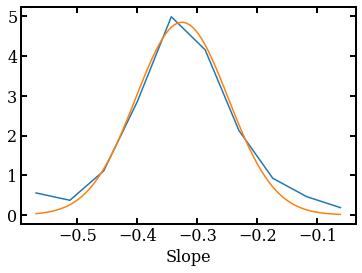

In [151]:
# Function to calculate the Gaussian with constants a, b, and c
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

N, edges = np.histogram(slope, density = True)
c = (edges[1:] + edges[:-1])/2
fig, ax = plt.subplots()
ax.set_xlabel('Slope',size=16)
ax.plot(c,N)
popt, pcov = curve_fit(gaussian, c, N)
x=np.linspace(c[0],c[-1],100)
ax.plot(x, gaussian(x,*popt))

(array(1.04841764), array(0.25648103), array(1.87457182), array(6.83552352))

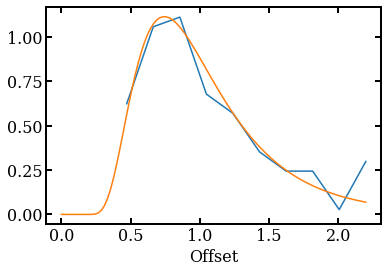

In [164]:
from scipy.stats import lognorm

N, edges = np.histogram(offset, density=True)
c = (edges[1:] + edges[:-1])/2
fig, ax = plt.subplots()
ax.set_xlabel('Offset',size=16)
ax.plot(c,N)
popt = lognorm.fit(offset)
x=np.linspace(0,c[-1],100)

ax.plot(x, lognorm.pdf(x,*popt))
lognorm.stats(*popt, moments='mvsk')

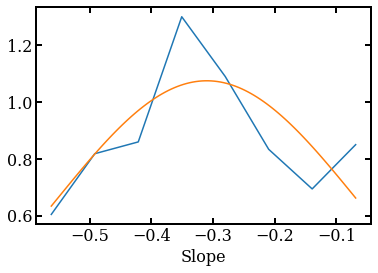

In [173]:
# Function to calculate the Gaussian with constants a, b, and c
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

N, edges, binnumber = binned_statistic(slope, offset, 'mean', bins=8)
c = (edges[1:] + edges[:-1])/2
fig, ax = plt.subplots()
ax.set_xlabel('Slope',size=16)
ax.plot(c,N)
popt, pcov = curve_fit(gaussian, c, N)
x=np.linspace(c[0],c[-1],100)
ax.plot(x, gaussian(x,*popt))

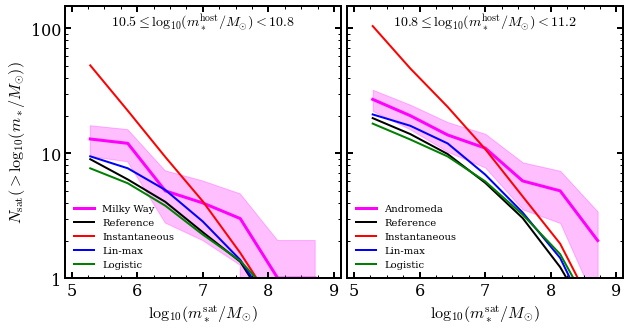

In [15]:
model_label = ['Reference', 'Instantaneous', 'Lin-max', 'Logistic']
model_color = ['black', 'red', 'blue', 'green']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]
mvir_range = [(np.log10(1e12), np.log10(2e12)),
              (np.log10(1.4e12), np.log10(5e12))]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_yscale('log')
ax[0].set_ylim([1,150])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax[0].set_ylabel('$N_{\mathrm{sat}}(>\log_{10}(m_*/M_{\odot}))$',size=16)


bins = np.histogram_bin_edges([5,9],bins=7)
hist, edges = np.histogram(MW_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[0].plot(mid, N, lw=3, color='magenta', label='Milky Way')
ax[0].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='magenta', alpha=0.25)

hist, edges = np.histogram(M31_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[1].plot(mid, N, lw=3, color='magenta', label='Andromeda')
ax[1].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='magenta', alpha=0.25)

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    min_mvir, max_mvir = mvir_range[i]
    axi.set_xlabel('$\log_{10}(m_*^{\mathrm{sat}}/M_{\odot})$', size=16)
    axi.set_xlim([4.9,9.1])
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,10,0.25)))
    full_label = '${:.1f}'.format(min_mstar)+'\leq \log_{10}(m^{\mathrm{host}}_*/M_{\odot})<'+'{:.1f}$'.format(max_mstar)
    axi.annotate(full_label, xy=(0.5, 1-0.02), xycoords='axes fraction', size=14, ha='center', va='top')
    
    for j, m in enumerate(models):
        hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0,min_mvir=min_mvir, max_mvir=max_mvir)
        Ntot = np.zeros(len(edges)-1)
        for index, row in hosts.iterrows():
            sats = m.galaxy.list(ihost=index, min_mstar=5)

            hist, _ = np.histogram(sats['Stellar_mass'].values, bins=bins)
            N = hist[::-1].cumsum()[::-1]
            #mid = (edges[1:] + edges[:-1])/2
            Ntot += N
        axi.plot(mid, Ntot/len(hosts), lw=2, color=model_color[j], label=model_label[j])
    
    axi.legend(frameon=False, loc='lower left')
#P60.savefig('cumulative_sat_smf.pdf', bbox_inches='tight')
plt.show()

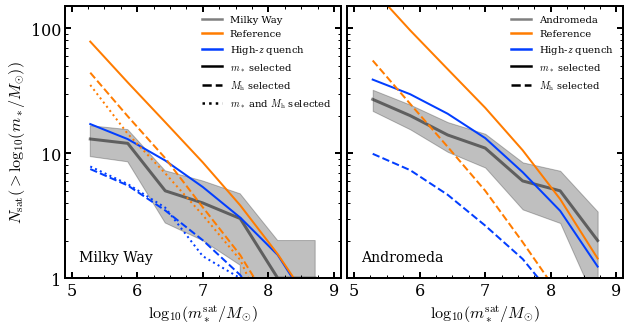

In [18]:
model_label = ['High-$z$ quench', 'Reference']
model_color = ['blue', 'green']
model_color = sns.color_palette('bright')
ls = ['-', '--', ':']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]
models = [P60_logistic, P60]
mvir_range = [(np.log10(1e12), np.log10(2e12)),
              (np.log10(1.4e12), np.log10(5e12))]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_yscale('log')
ax[0].set_ylim([1,150])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax[0].set_ylabel('$N_{\mathrm{sat}}(>\log_{10}(m_*/M_{\odot}))$',size=16)


bins = np.histogram_bin_edges([5,9],bins=7)
hist, edges = np.histogram(MW_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[0].plot(mid, N, lw=3, color='black', label='Milky Way', alpha=0.5)
ax[0].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)

hist, edges = np.histogram(M31_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[1].plot(mid, N, lw=3, color='black', label='Andromeda', alpha=0.5)
ax[1].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)

cases = [((10.6, 10.78, 0, np.inf),
         (5, np.inf, 12.0, 12.2),
         (10.6, 10.78, 12.0, 12.2)),
         ((10.93, 11.1, 0, np.inf),
         (5, np.inf, 12.15, 12.3),
         (10.93, 11.1, 12.15, 12.3))]

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    min_mvir, max_mvir = mvir_range[i]
    axi.set_xlabel('$\log_{10}(m_*^{\mathrm{sat}}/M_{\odot})$', size=16)
    axi.set_xlim([4.9,9.1])
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,10,0.25)))
    #full_label = '${:.1f}'.format(min_mstar)+'\leq \log_{10}(m^{\mathrm{host}}_*/M_{\odot})<'+'{:.1f}$'.format(max_mstar)
    #axi.annotate(full_label, xy=(0.5, 1-0.02), xycoords='axes fraction', size=14, ha='center', va='top')
    case = cases[i]
    for j, m in enumerate(models):
        for k, c in enumerate(case): 
            min_mstar, max_mstar, min_mvir, max_mvir = c
            hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0, min_mvir=min_mvir, max_mvir=max_mvir)
            Ntot = np.zeros(len(edges)-1)
            for index, row in hosts.iterrows():
                sats = m.galaxy.list(ihost=index, min_mstar=5)

                hist, _ = np.histogram(sats['Stellar_mass'].values, bins=bins)
                N = hist[::-1].cumsum()[::-1]
                #mid = (edges[1:] + edges[:-1])/2
                Ntot += N
            axi.plot(mid, Ntot/len(hosts), lw=2, color=model_color[j], ls=ls[k])
    
    #axi.legend(frameon=False, loc='lower left')
    
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Milky Way', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls=':', label='$m_*$ and $M_{\\mathrm{h}}$ selected')]
ax[0].legend(handles=handles, loc='upper right', frameon=False)

handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Andromeda', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected')]
ax[1].legend(handles=handles, loc='upper right', frameon=False)
ax[0].annotate('Milky Way', xy=(0.05, 0.05), xycoords='axes fraction', size=14, ha='left', va='bottom')
ax[1].annotate('Andromeda', xy=(0.05, 0.05), xycoords='axes fraction', size=14, ha='left', va='bottom')
#P60.savefig('cumulative_sat_smf.pdf', bbox_inches='tight')
plt.show()

In [639]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [569]:
cases = [((10.6, 10.78, 0, np.inf),
         (5, np.inf, 12.0, 12.2),
         (10.6, 10.78, 12.0, 12.2)),
         ((10.93, 11.1, 0, np.inf),
         (5, np.inf, 12.15, 12.3),
         (10.93, 11.1, 12.15, 12.3))]
for i, axi in enumerate(cases):
    case = cases[i]
    for j, c in enumerate(case):
        min_mstar, max_mstar, min_mvir, max_mvir = c
        print('min_mstar = {:.2f}, max_mstar = {:.2f}, min_mvir = {:.2f}, max_mvir = {:.2f}'.format(min_mstar, max_mstar, min_mvir, max_mvir))
    print('\n')

min_mstar = 10.60, max_mstar = 10.78, min_mvir = 0.00, max_mvir = inf
min_mstar = 5.00, max_mstar = inf, min_mvir = 12.00, max_mvir = 12.20
min_mstar = 10.60, max_mstar = 10.78, min_mvir = 12.00, max_mvir = 12.20


min_mstar = 10.93, max_mstar = 11.10, min_mvir = 0.00, max_mvir = inf
min_mstar = 5.00, max_mstar = inf, min_mvir = 12.15, max_mvir = 12.30
min_mstar = 10.93, max_mstar = 11.10, min_mvir = 12.15, max_mvir = 12.30




12.15

In [94]:
data = P60_logistic.galaxy.list(min_mstar=10.8, max_mstar=10.8, min_mvir=np.log10(1e12), max_mvir=np.log10(1.6e12))
sns.kdeplot(data=data, x="Halo_mass")

,Halo_mass,Halo_growth_rate,Halo_mass_peak,Halo_growth_peak,Halo_mass_host,Scale_peak_mass,Scale_half_mass,Halo_radius,Concentration,Halo_spin,...,X_pos,Y_pos,Z_pos,X_vel,Y_vel,Z_vel,Type,Desc_ID,Up_ID,Original_ID
ID,,,,,,,,,,,,,,,,,,,,,
36569532,12.051003,0.000000,12.136862,316.376495,0.0,0.70,0.40,274.036285,13.622462,0.05362,...,51.961536,57.148621,36.338223,-154.389999,-274.790009,-143.759995,1,0,1677991083,1865187890
36685065,12.048203,66.027130,12.171305,537.623657,0.0,0.61,0.44,273.452271,10.924236,0.03585,...,54.546322,56.971287,33.326809,-307.179993,-239.429993,117.779999,0,0,0,1865064249
160334992,12.084739,162.405640,12.288622,99.105049,0.0,0.81,0.38,281.226959,23.792887,0.03578,...,20.359150,16.934582,29.249699,-23.250000,-46.759998,78.720001,1,0,159253607,1855708195
178437564,12.168619,0.000000,12.253997,351.272980,0.0,0.91,0.53,299.933655,5.945365,0.02013,...,24.172171,11.098305,50.855186,141.669998,-27.410000,-11.300000,0,0,0,1857820526
232969524,12.179007,70.210945,12.179007,70.210945,0.0,1.00,0.49,302.365417,14.066547,0.07706,...,22.069000,25.588675,43.659756,116.599998,-65.019997,-22.639999,0,0,0,1858891245
296269294,12.195239,51.574295,12.200114,65.594215,0.0,0.99,0.55,306.083160,10.937187,0.01536,...,28.069061,42.659786,22.568398,160.089996,4.040000,73.739998,0,0,0,1859595109
317532754,12.165917,19.017094,12.176027,35.984013,0.0,0.93,0.55,299.311310,6.886872,0.04629,...,27.664104,41.183025,53.061440,50.820000,-143.729996,-250.259995,0,0,0,1859358301
317719729,12.000832,47.770859,12.000832,47.770859,0.0,1.00,0.59,263.694153,13.586430,0.08792,...,27.556364,42.939480,51.497108,264.519989,-144.139999,-211.210007,0,0,0,1859774753
346649213,12.194012,30.427311,12.194012,30.427311,0.0,1.00,0.44,305.794128,11.610897,0.01029,...,27.686373,59.413570,44.750034,40.860001,22.049999,19.350000,0,0,0,1859678492


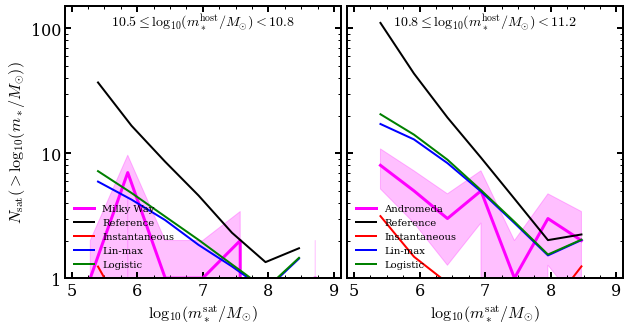

In [153]:
model_label = ['Reference', 'Instantaneous', 'Lin-max', 'Logistic']
model_color = ['black', 'red', 'blue', 'green']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]


fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_yscale('log')
ax[0].set_ylim([1,150])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax[0].set_ylabel('$N_{\mathrm{sat}}(>\log_{10}(m_*/M_{\odot}))$',size=16)

bins=7
bins = np.histogram_bin_edges([5,9],bins=7)
hist, edges = np.histogram(MW_sats['StellarMass'].values, bins=bins)
N = hist
mid = (edges[1:] + edges[:-1])/2
ax[0].plot(mid, N, lw=3, color='magenta', label='Milky Way')
ax[0].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='magenta', alpha=0.25)

bins=7
hist, edges = np.histogram(M31_sats['StellarMass'].values, bins=bins)
N = hist
mid = (edges[1:] + edges[:-1])/2
ax[1].plot(mid, N, lw=3, color='magenta', label='Andromeda')
ax[1].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='magenta', alpha=0.25)

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    axi.set_xlabel('$\log_{10}(m_*^{\mathrm{sat}}/M_{\odot})$', size=16)
    axi.set_xlim([4.9,9.1])
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,10,0.25)))
    full_label = '${:.1f}'.format(min_mstar)+'\leq \log_{10}(m^{\mathrm{host}}_*/M_{\odot})<'+'{:.1f}$'.format(max_mstar)
    axi.annotate(full_label, xy=(0.5, 1-0.02), xycoords='axes fraction', size=14, ha='center', va='top')
    
    
    for j, m in enumerate(models):
        hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0)
        Ntot = np.zeros(len(edges)-1)
        for index, row in hosts.iterrows():
            sats = m.galaxy.list(ihost=index, min_mstar=5)

            hist, _ = np.histogram(sats['Stellar_mass'].values, bins=bins)
            N = hist
            Ntot += N
        axi.plot(mid, Ntot/len(hosts), lw=2, color=model_color[j], label=model_label[j])
    
    axi.legend(frameon=False, loc='lower left')
P60.savefig('sat_smf.pdf', bbox_inches='tight')
plt.show()

MW
Reference
    N=166
    Mvir: 12.29+-0.20
    Rvir: 332.69+-48.80
0.20137474
Instantaneous
    N=135
    Mvir: 12.44+-0.18
    Rvir: 371.81+-50.26
0.17969549
Lin-max
    N=150
    Mvir: 12.36+-0.16
    Rvir: 349.62+-42.77
0.16192514
Logistic
    N=150
    Mvir: 12.36+-0.16
    Rvir: 349.62+-42.77
0.16192514
M31
Reference
    N=131
    Mvir: 12.76+-0.21
    Rvir: 477.22+-81.36
0.21445407
Instantaneous
    N=95
    Mvir: 12.87+-0.21
    Rvir: 521.65+-90.24
0.2128124
Lin-max
    N=121
    Mvir: 12.80+-0.22
    Rvir: 493.53+-89.06
0.2218298
Logistic
    N=121
    Mvir: 12.80+-0.22
    Rvir: 493.53+-89.06
0.2218298


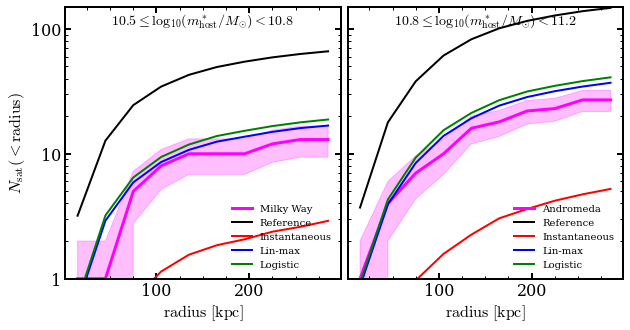

In [80]:
model_label = ['Reference', 'Instantaneous', 'Lin-max', 'Logistic']
model_color = ['black', 'red', 'blue', 'green']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]


fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_yscale('log')
ax[0].set_ylim([1,150])
ax[0].set_ylabel('$N_{\mathrm{sat}}(<\mathrm{radius})$',size=16)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))


bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(MW_sats['r_MW'], bins=bins)
N = hist.cumsum()
mid = (bins[1:] + bins[:-1])/2
ax[0].plot(mid, N, lw=3, color='magenta', label='Milky Way')
ax[0].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='magenta', alpha=0.25)


bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(M31_sats['r_M31'], bins=bins)
N = hist.cumsum()
ax[1].plot(mid, N, lw=3, color='magenta', label='Andromeda')
ax[1].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='magenta', alpha=0.25)
h = ['MW', 'M31']
for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    axi.set_xlabel('$\mathrm{radius\,\,[kpc]}$',size=16)
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,500,25)))
    full_label = '${:.1f}'.format(min_mstar)+'\leq \log_{10}(m^*_{\mathrm{host}}/M_{\odot})<'+'{:.1f}$'.format(max_mstar)
    axi.annotate(full_label, xy=(0.5, 1-0.02), xycoords='axes fraction', size=14, ha='center', va='top')
    print(h[i])
    for j, m in enumerate(models):
        hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0)
        Ntot = np.zeros(len(bins)-1)
        print(model_label[j])
        print('    N={:d}\n    Mvir: {:.2f}+-{:.2f}\n    Rvir: {:.2f}+-{:.2f}'.format(len(hosts), hosts.Halo_mass.mean(), hosts.Halo_mass.std(), hosts.Halo_radius.mean(), hosts.Halo_radius.std()))
        print(hosts.Halo_mass.std())

        for index, row in hosts.iterrows():
            sats = m.galaxy.list(ihost=index, min_mstar=5)
            pos = sats[['X_pos','Y_pos','Z_pos']].values
            xs, ys, zs = pos[:,0], pos[:,1], pos[:,2]

            x,y,z = row[['X_pos','Y_pos','Z_pos']].values
            xc, yc, zc = [x]*len(pos), [y]*len(pos), [z]*len(pos)
            r_sat = radial_distance(xs, ys, zs, xc, yc, zc, period=m.params.get_param('BoxSize')/m.cosmology.h)
            hist, _ = np.histogram(r_sat*1000, bins=bins)
            N = hist.cumsum()
            Ntot += N
        axi.plot(mid, Ntot/len(hosts), lw=2, color=model_color[j], label=model_label[j])
    
    axi.legend(frameon=False, loc='lower right')
#P60.savefig('cumulative_sat_dist.pdf', bbox_inches='tight')
plt.show()

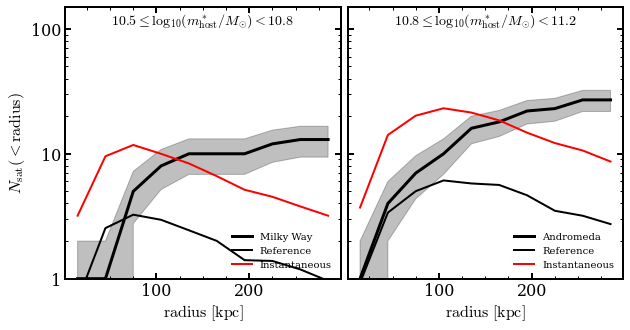

In [594]:
model_label = ['Reference', 'Instantaneous', 'Lin-max', 'Logistic']
model_color = ['black', 'red', 'blue', 'green']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]


fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_yscale('log')
ax[0].set_ylim([1,150])
ax[0].set_ylabel('$N_{\mathrm{sat}}(<\mathrm{radius})$',size=16)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))


bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(MW_sats['r_MW'], bins=bins)
N = hist.cumsum()
mid = (bins[1:] + bins[:-1])/2
ax[0].plot(mid, N, lw=3, color='black', label='Milky Way')
ax[0].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='magenta', alpha=0.25)


bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(M31_sats['r_M31'], bins=bins)
N = hist.cumsum()
ax[1].plot(mid, N, lw=3, color='black', label='Andromeda')
ax[1].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='magenta', alpha=0.25)

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    axi.set_xlabel('$\mathrm{radius\,\,[kpc]}$',size=16)
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,500,25)))
    full_label = '${:.1f}'.format(min_mstar)+'\leq \log_{10}(m^*_{\mathrm{host}}/M_{\odot})<'+'{:.1f}$'.format(max_mstar)
    axi.annotate(full_label, xy=(0.5, 1-0.02), xycoords='axes fraction', size=14, ha='center', va='top')
    
    
    for j, m in enumerate(models):
        hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0)
        Ntot = np.zeros(len(bins)-1)

        for index, row in hosts.iterrows():
            sats = m.galaxy.list(ihost=index, min_mstar=5)
            pos = sats[['X_pos','Y_pos','Z_pos']].values
            xs, ys, zs = pos[:,0], pos[:,1], pos[:,2]

            x,y,z = row[['X_pos','Y_pos','Z_pos']].values
            xc, yc, zc = [x]*len(pos), [y]*len(pos), [z]*len(pos)
            r_sat = radial_distance(xs, ys, zs, xc, yc, zc, period=m.params.get_param('BoxSize')/m.cosmology.h)
            hist, _ = np.histogram(r_sat*1000, bins=bins)
            N = hist
            Ntot += N
        axi.plot(mid, Ntot/len(hosts), lw=2, color=model_color[j], label=model_label[j])
    
    axi.legend(frameon=False, loc='lower right')

P60.savefig('sat_dist.pdf', bbox_inches='tight')

plt.show()

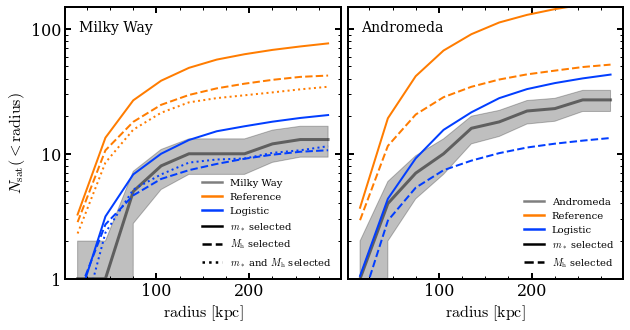

In [607]:
model_label = ['Logistic', 'Reference']
model_color = ['blue', 'green']
model_color = sns.color_palette('bright')
ls = ['-', '--', ':']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]
models = [P60_logistic, P60]
mvir_range = [(np.log10(1e12), np.log10(2e12)),
              (np.log10(1.4e12), np.log10(5e12))]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_yscale('log')
ax[0].set_ylim([1,150])
ax[0].set_ylabel('$N_{\mathrm{sat}}(<\mathrm{radius})$',size=16)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))


bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(MW_sats['r_MW'], bins=bins)
N = hist.cumsum()
mid = (bins[1:] + bins[:-1])/2
ax[0].plot(mid, N, lw=3, color='black', label='Milky Way', alpha=0.5)
ax[0].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)


bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(M31_sats['r_M31'], bins=bins)
N = hist.cumsum()
ax[1].plot(mid, N, lw=3, color='black', label='Andromeda', alpha=0.5)
ax[1].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)

cases = [((10.6, 10.78, 0, np.inf),
         (5, np.inf, 12.0, 12.2),
         (10.6, 10.78, 12.0, 12.2)),
         ((10.93, 11.1, 0, np.inf),
         (5, np.inf, 12.15, 12.3),
         (10.93, 11.1, 12.15, 12.3))]

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    min_mvir, max_mvir = mvir_range[i]
    axi.set_xlabel('$\mathrm{radius\,\,[kpc]}$',size=16)
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,500,25)))
    #full_label = '${:.1f}'.format(min_mstar)+'\leq \log_{10}(m^{\mathrm{host}}_*/M_{\odot})<'+'{:.1f}$'.format(max_mstar)
    #axi.annotate(full_label, xy=(0.5, 1-0.02), xycoords='axes fraction', size=14, ha='center', va='top')
    case = cases[i]
    for j, m in enumerate(models):
        for k, c in enumerate(case):
            Ntot = np.zeros(len(bins)-1)
            min_mstar, max_mstar, min_mvir, max_mvir = c
            hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0, min_mvir=min_mvir, max_mvir=max_mvir)
            #Ntot = np.zeros(len(edges)-1)
            for index, row in hosts.iterrows():
                sats = m.galaxy.list(ihost=index, min_mstar=5)
                pos = sats[['X_pos','Y_pos','Z_pos']].values
                xs, ys, zs = pos[:,0], pos[:,1], pos[:,2]

                x,y,z = row[['X_pos','Y_pos','Z_pos']].values
                xc, yc, zc = [x]*len(pos), [y]*len(pos), [z]*len(pos)
                r_sat = radial_distance(xs, ys, zs, xc, yc, zc, period=m.params.get_param('BoxSize')/m.cosmology.h)
                hist, _ = np.histogram(r_sat*1000, bins=bins)
                N = hist.cumsum()
                Ntot += N
            axi.plot(mid, Ntot/len(hosts), lw=2, color=model_color[j], ls=ls[k])
    
    #axi.legend(frameon=False, loc='lower left')
    
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Milky Way', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='Logistic'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls=':', label='$m_*$ and $M_{\\mathrm{h}}$ selected')]
ax[0].legend(handles=handles, loc='lower right', frameon=False)

handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Andromeda', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='Logistic'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected')]
ax[1].legend(handles=handles, loc='lower right', frameon=False)
ax[0].annotate('Milky Way', xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
ax[1].annotate('Andromeda', xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
#P60.savefig('cumulative_sat_smf.pdf', bbox_inches='tight')
plt.show()

365.53848
283.58118
293.93033
354.5966
283.58118
289.14435
511.98407
312.55392
nan
495.77292
312.5539
nan


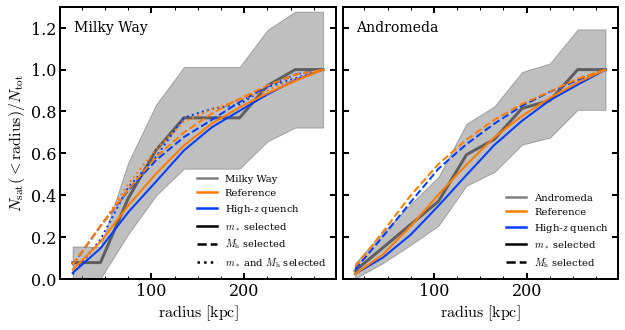

In [30]:
model_label = ['Logistic', 'Reference']
model_color = ['blue', 'green']
model_color = sns.color_palette('bright')
ls = ['-', '--', ':']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]
models = [P60_logistic, P60]
mvir_range = [(np.log10(1e12), np.log10(2e12)),
              (np.log10(1.4e12), np.log10(5e12))]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
#ax[0].set_yscale('log')
ax[0].set_ylim([0,1.3])
ax[0].set_ylabel('$N_{\mathrm{sat}}(<\mathrm{radius})/N_{\\mathrm{tot}}$',size=16)
#ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))


bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(MW_sats['r_MW'], bins=bins)
N = hist.cumsum()
mid = (bins[1:] + bins[:-1])/2
ax[0].plot(mid, N/N[-1], lw=3, color='black', label='Milky Way', alpha=0.5)
ax[0].fill_between(mid, (N+np.sqrt(N))/N[-1], (N-np.sqrt(N))/N[-1], color='black', alpha=0.25)


bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(M31_sats['r_M31'], bins=bins)
N = hist.cumsum()
ax[1].plot(mid, N/N[-1], lw=3, color='black', label='Andromeda', alpha=0.5)
ax[1].fill_between(mid, (N+np.sqrt(N))/N[-1], (N-np.sqrt(N))/N[-1], color='black', alpha=0.25)

cases = [((10.6, 10.78, 0, np.inf),
         (5, np.inf, 12.0, 12.2),
         (10.6, 10.78, 12.0, 12.2)),
         ((10.93, 11.1, 0, np.inf),
         (5, np.inf, 12.15, 12.3),
         (10.93, 11.1, 12.15, 12.3))]

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    min_mvir, max_mvir = mvir_range[i]
    axi.set_xlabel('$\mathrm{radius\,\,[kpc]}$',size=16)
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,500,25)))
    #full_label = '${:.1f}'.format(min_mstar)+'\leq \log_{10}(m^{\mathrm{host}}_*/M_{\odot})<'+'{:.1f}$'.format(max_mstar)
    #axi.annotate(full_label, xy=(0.5, 1-0.02), xycoords='axes fraction', size=14, ha='center', va='top')
    case = cases[i]
    for j, m in enumerate(models):
        for k, c in enumerate(case):
            Ntot = np.zeros(len(bins)-1)
            min_mstar, max_mstar, min_mvir, max_mvir = c
            hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0, min_mvir=min_mvir, max_mvir=max_mvir)
            print(hosts.Halo_radius.mean())
            for index, row in hosts.iterrows():
                sats = m.galaxy.list(ihost=index, min_mstar=5)
                pos = sats[['X_pos','Y_pos','Z_pos']].values
                xs, ys, zs = pos[:,0], pos[:,1], pos[:,2]

                x,y,z = row[['X_pos','Y_pos','Z_pos']].values
                xc, yc, zc = [x]*len(pos), [y]*len(pos), [z]*len(pos)
                r_sat = radial_distance(xs, ys, zs, xc, yc, zc, period=m.params.get_param('BoxSize')/m.cosmology.h)
                hist, _ = np.histogram(r_sat*1000, bins=bins)
                N = hist.cumsum()
                Ntot += N
                Nmax = Ntot[-1]/len(hosts)
            axi.plot(mid, Ntot/len(hosts)/Nmax, lw=2, color=model_color[j], ls=ls[k])
    
    #axi.legend(frameon=False, loc='lower left')
    
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Milky Way', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls=':', label='$m_*$ and $M_{\\mathrm{h}}$ selected')]
ax[0].legend(handles=handles, loc='lower right', frameon=False)

handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Andromeda', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected')]
ax[1].legend(handles=handles, loc='lower right', frameon=False)
ax[0].annotate('Milky Way', xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
ax[1].annotate('Andromeda', xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
P60.savefig('cumulative_sat_smf_normed.pdf', bbox_inches='tight')
plt.show()

In [11]:
def log_efficiency(M, M1, eps_N, beta, gamma):
    return np.log10(2*eps_N)-np.log10((10**(M-M1))**(-beta) + (10**(M-M1))**gamma)

def scatter(M,  M_sig, sig_0, alpha):
    return sig_0 + np.log10( (10**(M-M_sig))**(-alpha) + 1)

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

[11.94454278  0.10774536  1.50705085  0.44978725]


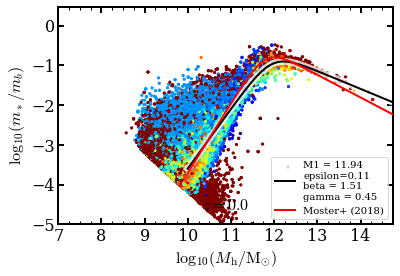

scatter params: M_sig=11.96, sig_0=-0.09, alpha=0.29


In [106]:
model = P60_linmax

# setup the data
vmin, vmax = -12.5, -8.9 
mh_min, mh_max, bin_size = 10, 13.7, 0.2
redshift=0
galaxies = model.galaxy.list(z=redshift, min_mstar=5) # select only type 0 galaxies
f_baryon = model.cosmology.Ob0 / model.cosmology.Om0

mbin=np.arange(mh_min,mh_max,bin_size)
#mbin     = np.arange(np.max([np.min(np.log10(mhalo)),xmin]), np.min([np.max(np.log10(mhalo)),xmax]), bs)
X = galaxies['Halo_mass_peak']
Y = np.log10(10**galaxies['Stellar_mass'] / ((10**galaxies['Halo_mass_peak']) * f_baryon))
color = np.log10(galaxies['SFR'] / (10**galaxies['Stellar_mass']))
color.loc[color == -np.inf] = vmin

# bin data
mhalo,_,_ = binned_statistic(X, X, statistic='mean', bins=mbin)
eff,_,_ = binned_statistic(X, Y, statistic='mean', bins=mbin)
sigma,_,_ = binned_statistic(X, Y, statistic=np.std, bins=mbin)

# fit efficiency
popt, pcov = curve_fit(log_efficiency, mhalo, eff, p0=[12.0, 0.13, 1.3, 0.6],maxfev=10000)
print(popt)
#plotting
L = 6
frac=1 # plotting fraction for scatter
fig, ax = plt.subplots(1,1)
ax.set_ylim([-5,0.47])
N = len(X)
samp = int(N*frac)
args = np.random.choice(np.arange(0,N), size=samp)
ln = ax.scatter(X.values[args], Y.values[args], s=5, c=color.values[args], cmap=plt.cm.jet_r, vmin=vmin, vmax=vmax)

label = 'M1 = {:.2f}\nepsilon={:.2f}\nbeta = {:.2f} \ngamma = {:.2f}'.format(*popt)
old = np.array([11.80, 0.14, 1.75, 0.57])

ax.plot(np.arange(10,15,0.1),log_efficiency(np.arange(10,15,0.1),*popt),'k-',lw=2,zorder=10, label=label)
ax.plot(np.arange(10,15,0.1),log_efficiency(np.arange(10,15,0.1),*popt),color='white',lw=7,alpha=0.75)
ax.plot(np.arange(10,15,0.1),log_efficiency(np.arange(10,15,0.1),*old),'r-',lw=2,zorder=10, label='Moster+ (2018)')

ax.set_ylabel('$\log_{10}(m_*/m_b)$',size = 16)
ax.set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(7, 14.5+1, 0.25)))
ax.annotate('$z={:.1f}$'.format(redshift), xy=(0.5, 0.05), xycoords='axes fraction', size=16, ha='center', va='bottom')

ax.xaxis.set_ticks(np.arange(7,15))
ax.set_xlim([7,14.75])
ax.legend()
plt.show()

# fit scatter
popt, pcov = curve_fit(scatter, mhalo, sigma, p0=[10.80, 0.16, 1.00],maxfev=10000)
print('scatter params: M_sig={:.2f}, sig_0={:.2f}, alpha={:.2f}'.format(*popt))


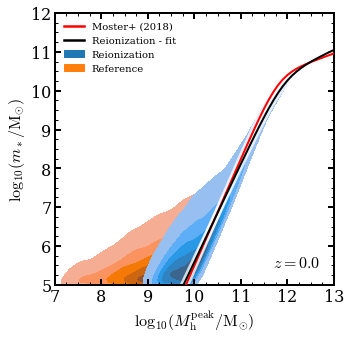

In [461]:
model = P60_logistic
def double_power(x, a, b, c, d):
    return x+b-np.log10((10.**(x-a))**(-c)+(10.**(x-a))**(d))

def tripple_power(x, a, b, c, d, e, f):
    return x+b-np.log10((10.**(x-f))**(-e) (10.**(x-a))**(-c)+(10.**(x-a))**(d))

# setup the data
vmin, vmax = -12.5, -8.9 
mh_min, mh_max, bin_size = 10, 13.7, 0.2
redshift=0
galaxies = model.galaxy.list(z=redshift, min_mstar=5) # select only type 0 galaxies
f_baryon = model.cosmology.Ob0 / model.cosmology.Om0

mbin=np.arange(mh_min,mh_max,bin_size)
#mbin     = np.arange(np.max([np.min(np.log10(mhalo)),xmin]), np.min([np.max(np.log10(mhalo)),xmax]), bs)
X = galaxies['Halo_mass_peak']
Y = galaxies['Stellar_mass']
color = np.log10(galaxies['SFR'] / (10**galaxies['Stellar_mass']))
color.loc[color == -np.inf] = vmin



# fit efficiency
#popt, pcov = curve_fit(log_efficiency, mhalo, eff, p0=[10.0, 1, 1, 1],maxfev=10000)
#print(popt)
#mbin=np.arange(9,13.7,0.2)
mhalo,_,_ = binned_statistic(galaxies['Halo_mass_peak'], galaxies['Halo_mass_peak'], statistic='mean',bins=mbin)
mstar,_,_= binned_statistic(galaxies['Halo_mass_peak'], galaxies['Stellar_mass'], statistic='mean',bins=mbin)
popt, pcov = curve_fit(double_power, mhalo, mstar,p0=[10,1,1,1],maxfev=10000)
#plotting
L = 6
frac=1 # plotting fraction for scatter
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_ylim([5,12])
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
N = len(X)
samp = int(N*frac)
args = np.random.choice(np.arange(0,N), size=samp)
sns.kdeplot(data=galaxies, x='Halo_mass_peak', y="Stellar_mass", ax=ax, levels=6, fill=True)

glist = P60.galaxy.list(z=redshift, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax, levels=6, fill=True, zorder=0)

old = np.array([11.80, 0.14, 1.75, 0.57])

x = np.arange(9,15,0.1)
ax.plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='r',lw=2,zorder=10, label='Moster+ (2018)')
ax.plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='white',lw=7,alpha=0.75)

ax.plot(x,double_power(x,*popt),color='black',lw=2,zorder=10)
ax.plot(x,double_power(x,*popt),color='white',lw=7,alpha=0.75)

ax.set_ylabel('$\log_{10}(m_*/\mathrm{M}_{\odot})$',size = 16)
ax.set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)


ax.annotate('$z={:.1f}$'.format(redshift), xy=(1-0.05, 0.05), xycoords='axes fraction', size=16, ha='right', va='bottom')
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(7, 14.5+1, 0.25)))
ax.xaxis.set_ticks(np.arange(7,15))
ax.set_xlim([7,13])
ax.set_ylim([5,12])
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))

handles = [Line2D([0], [0], color='r', lw=2.5, ls='-', label='Moster+ (2018)'),
           Line2D([0], [0], color='k', lw=2.5, ls='-', label='Reionization - fit'),
           patches.Patch(color=sns.color_palette()[0], label='Reionization'),
           patches.Patch(color=sns.color_palette()[1], label='Reference') ]
ax.legend(handles=handles, frameon=False)
P60.savefig('SHMR_talk.pdf', bbox_inches='tight')
plt.show()
# fit scatter
#popt, pcov = curve_fit(scatter, mhalo, sigma, p0=[10.80, 0.16, 1.00],maxfev=10000)
#print('scatter params: M_sig={:.2f}, sig_0={:.2f}, alpha={:.2f}'.format(*popt))



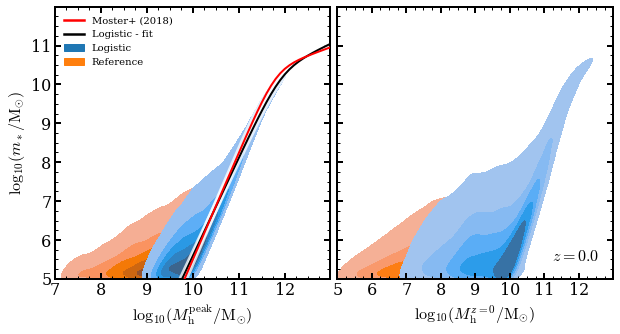

In [386]:

model = P60_logistic
def double_power(x, a, b, c, d):
    return x+b-np.log10((10.**(x-a))**(-c)+(10.**(x-a))**(d))

def tripple_power(x, a, b, c, d, e, f):
    return x+b-np.log10((10.**(x-f))**(-e) (10.**(x-a))**(-c)+(10.**(x-a))**(d))

# setup the data
vmin, vmax = -12.5, -8.9 
mh_min, mh_max, bin_size = 10, 13.7, 0.2
redshift=0
galaxies = model.galaxy.list(z=redshift, min_mstar=5) # select only type 0 galaxies
f_baryon = model.cosmology.Ob0 / model.cosmology.Om0

mbin=np.arange(mh_min,mh_max,bin_size)

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_ylim([5,11.99])
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[0].set_ylabel('$\log_{10}(m_*/\mathrm{M}_{\odot})$',size = 16)
ax[0].set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M^{z=0}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

#for i, axi in enumerate(ax.reshape(-1)):
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(7, 14.5+1, 0.25)))
ax[0].xaxis.set_ticks(np.arange(7,15))
ax[0].set_xlim([7,12.99])

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[1].xaxis.set_ticks(np.arange(4,15))
ax[1].set_xlim([5,12.99])

# plot contours
glist = P60_logistic.galaxy.list(z=redshift, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[0], levels=6, fill=True)
sns.kdeplot(data=glist, x='Halo_mass', y="Stellar_mass", ax=ax[1], levels=6, fill=True)
mhalo,_,_ = binned_statistic(glist['Halo_mass_peak'], glist['Halo_mass_peak'], statistic='mean',bins=mbin)
mstar,_,_= binned_statistic(glist['Halo_mass_peak'], glist['Stellar_mass'], statistic='mean',bins=mbin)
popt, pcov = curve_fit(double_power, mhalo, mstar,p0=[10,1,1,1],maxfev=10000)
ax[0].plot(x,double_power(x,*popt),color='black',lw=2,zorder=10)
ax[0].plot(x,double_power(x,*popt),color='white',lw=7,alpha=0.75)

glist = P60.galaxy.list(z=redshift, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[0], levels=6, fill=True, zorder=0)
sns.kdeplot(data=glist, x='Halo_mass', y="Stellar_mass", ax=ax[1], levels=6, fill=True, zorder=0)

# moster 2018
x = np.arange(9,15,0.1)
old = np.array([11.80, 0.14, 1.75, 0.57])
ax[0].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='r',lw=2,zorder=10, label='Moster+ (2018)')
ax[0].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='white',lw=7,alpha=0.75)

ax[1].annotate('$z={:.1f}$'.format(redshift), xy=(1-0.05, 0.05), xycoords='axes fraction', size=16, ha='right', va='bottom')

handles = [Line2D([0], [0], color='r', lw=2.5, ls='-', label='Moster+ (2018)'),
           Line2D([0], [0], color='k', lw=2.5, ls='-', label='Logistic - fit'),
           patches.Patch(color=sns.color_palette()[0], label='Logistic'),
           patches.Patch(color=sns.color_palette()[1], label='Reference') ]
ax[0].legend(handles=handles, frameon=False)
P60.savefig('SHMR_joint.pdf', bbox_inches='tight')

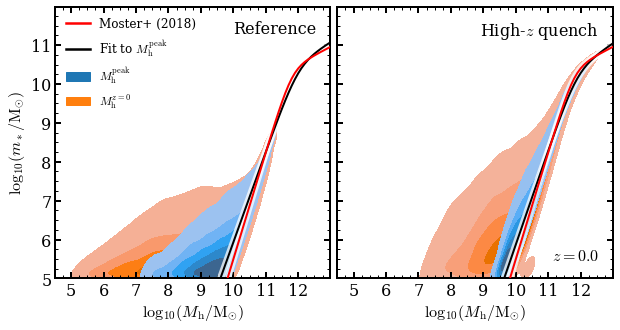

In [34]:

model = P60_logistic
def double_power(x, a, b, c, d):
    return x+b-np.log10((10.**(x-a))**(-c)+(10.**(x-a))**(d))

def tripple_power(x, a, b, c, d, e, f):
    return x+b-np.log10((10.**(x-f))**(-e) (10.**(x-a))**(-c)+(10.**(x-a))**(d))

# setup the data
vmin, vmax = -12.5, -8.9 
mh_min, mh_max, bin_size = 10, 13.7, 0.2
mbin=np.arange(mh_min,mh_max,bin_size)
redshift=0
galaxies = model.galaxy.list(z=redshift, min_mstar=5) # select only type 0 galaxies
f_baryon = model.cosmology.Ob0 / model.cosmology.Om0

mbin=np.arange(mh_min,mh_max,bin_size)

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_ylim([5,11.99])
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[0].set_ylabel('$\log_{10}(m_*/\mathrm{M}_{\odot})$',size = 16)
ax[0].set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M^{z=0}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[0].set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

#for i, axi in enumerate(ax.reshape(-1)):
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[0].xaxis.set_ticks(np.arange(4,15))
ax[0].set_xlim([4.5,12.99])

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[1].xaxis.set_ticks(np.arange(4,15))
ax[1].set_xlim([4.5,12.99])

# Reference model
glist = P60.galaxy.list(z=redshift, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[0], levels=6, fill=True)
sns.kdeplot(data=glist, x='Halo_mass', y="Stellar_mass", ax=ax[0], levels=6, fill=True, zorder=0)
mhalo,_,_ = binned_statistic(glist['Halo_mass_peak'], glist['Halo_mass_peak'], statistic='mean',bins=mbin)
mstar,_,_= binned_statistic(glist['Halo_mass_peak'], glist['Stellar_mass'], statistic='mean',bins=mbin)
popt, pcov = curve_fit(double_power, mhalo, mstar,p0=[10,1,1,1],maxfev=10000)
ax[0].plot(x,double_power(x,*popt),color='black',lw=2,zorder=10)
ax[0].plot(x,double_power(x,*popt),color='white',lw=7,alpha=0.75)
ax[0].annotate('Reference', xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=16, ha='right', va='top',color='k')


# logistic
glist = P60_logistic.galaxy.list(z=redshift, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[1], levels=6, fill=True)
sns.kdeplot(data=glist, x='Halo_mass', y="Stellar_mass", ax=ax[1], levels=6, fill=True,zorder=0)
mhalo,_,_ = binned_statistic(glist['Halo_mass_peak'], glist['Halo_mass_peak'], statistic='mean',bins=mbin)
mstar,_,_= binned_statistic(glist['Halo_mass_peak'], glist['Stellar_mass'], statistic='mean',bins=mbin)
popt, pcov = curve_fit(double_power, mhalo, mstar,p0=[10,1,1,1],maxfev=10000)
ax[1].plot(x,double_power(x,*popt),color='black',lw=2,zorder=10)
ax[1].plot(x,double_power(x,*popt),color='white',lw=7,alpha=0.75)
ax[1].annotate('High-$z$ quench', xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=16, ha='right', va='top',color='k')


# moster 2018
x = np.arange(9,15,0.1)
old = np.array([11.80, 0.14, 1.75, 0.57])
ax[0].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='r',lw=2,zorder=10, label='Moster+ (2018)')
ax[0].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='white',lw=7,alpha=0.75)
ax[1].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='r',lw=2,zorder=10, label='Moster+ (2018)')
ax[1].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='white',lw=7,alpha=0.75)

ax[1].annotate('$z={:.1f}$'.format(redshift), xy=(1-0.05, 0.05), xycoords='axes fraction', size=16, ha='right', va='bottom')

handles = [Line2D([0], [0], color='r', lw=2.5, ls='-', label='Moster+ (2018)'),
           Line2D([0], [0], color='k', lw=2.5, ls='-', label='Fit to $M^{\mathrm{peak}}_{\mathrm{h}}$'),
           patches.Patch(color=sns.color_palette()[0], label='$M^{\mathrm{peak}}_{\mathrm{h}}$'),
           patches.Patch(color=sns.color_palette()[1], label='$M^{z=0}_{\mathrm{h}}$') ]
ax[0].legend(handles=handles, frameon=False, fontsize=12)
P60.savefig('SHMR_split.pdf', bbox_inches='tight')

& $9.55_{-2.07}^{+0.28}$ & $9.88_{-1.18}^{+0.23}$ \\
& $9.85_{-2.04}^{+0.28}$ & $10.11_{-1.24}^{+0.23}$ \\
& $10.13_{-1.91}^{+0.29}$ & $10.33_{-1.35}^{+0.24}$ \\
& $10.40_{-1.76}^{+0.30}$ & $10.53_{-1.51}^{+0.27}$ \\
& $10.62_{-1.59}^{+0.31}$ & $10.71_{-1.33}^{+0.30}$ \\
& $10.84_{-1.39}^{+0.34}$ & $10.89_{-0.98}^{+0.31}$ \\
& $11.03_{-0.95}^{+0.36}$ & $11.06_{-0.73}^{+0.31}$ \\
& $11.22_{-0.68}^{+0.35}$ & $11.24_{-0.50}^{+0.30}$ \\


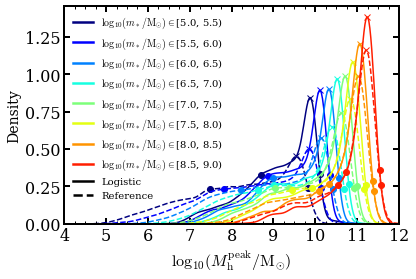

In [369]:
def color(n, tot):
    return plt.cm.jet(n / tot, 1)

mbin = np.arange(5,9.5,0.5)
percentile=68    

handles = []
fig, ax = plt.subplots()
ax.set_ylabel('Density', size = 14)
ax.set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax.xaxis.set_ticks(np.arange(4,15))
ax.set_xlim([4,12])

models = [P60, P60_logistic]
ls = ['--', '-']
for i in range(len(mbin)-1):
    txt = ''
    
    for j, m in enumerate(models):
        glist = m.galaxy.list(z=redshift, min_mstar=mbin[i], max_mstar=mbin[i+1])
        sns.kdeplot(glist['Halo_mass'].values, color=color(i, len(mbin)-1), ax=ax, ls=ls[j])
        
        k = kde.gaussian_kde(glist['Halo_mass'].values)
        x = np.linspace(4,12,1000)
        y = k.evaluate(x)
        #peak, _ = find_peaks(y, height=0.5*y.max())
        peak = np.argmax(y)
        n=0
        mask = y > y[peak]*(0.95-n*0.01)
        while integrate.simpson(y[mask],x[mask]) < 0.68:
            n+=1
            mask = y > y[peak]*(0.98-n*0.01)

        q  = np.abs(x[mask][[0,-1]] - x[peak])

        s = '& ${0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}$ '
        txt += s.format(x[peak], q[0], q[1])
        ax.plot(x[peak], y[peak], 'x', color=color(i, len(mbin)-1))
        ax.plot(x[mask][[0,-1]], y[mask][[0,-1]], 'o', color=color(i, len(mbin)-1))
        #ax.axvline(mcmc[1],0,3,ls=ls[j], color=color(i, len(mbin)-1))


    label = '$\log_{10}(m_*/\mathrm{M}_{\odot}) \in$' + '[{:.1f}, {:.1f})'.format(mbin[i], mbin[i+1])
    handles += [Line2D([0], [0], color=color(i, len(mbin)-1), lw=2.5, ls='-', label=label)]
    txt += '\\\\'
    print(txt)

handles += [Line2D([0], [0], color='k', lw=2.5, ls='-', label='Logistic'),
            Line2D([0], [0], color='k', lw=2.5, ls='--', label='Reference')]
ax.legend(handles=handles, frameon=False)
#P60.savefig('SHMR_scatter_mstar.pdf', bbox_inches='tight')

$\in [5.0, 5.5)$ & $133120$ & $0.31$ & $9.44_{-0.82}^{+0.32}$ & $9.55_{-2.07}^{+0.28}$ & $9717$ & $0.20$ & $9.60_{-0.14}^{+0.23}$ & $9.80_{-1.31}^{+0.21}$ \\
$\in [5.5, 6.0)$ & $65644$ & $0.26$ & $9.77_{-0.79}^{+0.28}$ & $9.85_{-2.04}^{+0.28}$ & $11959$ & $0.14$ & $9.97_{-0.24}^{+0.13}$ & $10.02_{-0.98}^{+0.21}$ \\
$\in [6.0, 6.5)$ & $32887$ & $0.22$ & $10.09_{-0.74}^{+0.24}$ & $10.13_{-1.91}^{+0.29}$ & $10445$ & $0.12$ & $10.21_{-0.26}^{+0.12}$ & $10.23_{-0.87}^{+0.22}$ \\
$\in [6.5, 7.0)$ & $16474$ & $0.21$ & $10.39_{-0.66}^{+0.19}$ & $10.40_{-1.76}^{+0.30}$ & $7815$ & $0.12$ & $10.42_{-0.25}^{+0.13}$ & $10.43_{-0.82}^{+0.23}$ \\
$\in [7.0, 7.5)$ & $8453$ & $0.19$ & $10.63_{-0.54}^{+0.18}$ & $10.62_{-1.59}^{+0.31}$ & $5516$ & $0.12$ & $10.61_{-0.23}^{+0.13}$ & $10.61_{-0.78}^{+0.25}$ \\
$\in [7.5, 8.0)$ & $4524$ & $0.19$ & $10.85_{-0.42}^{+0.16}$ & $10.84_{-1.39}^{+0.34}$ & $3586$ & $0.13$ & $10.81_{-0.21}^{+0.13}$ & $10.81_{-0.71}^{+0.27}$ \\
$\in [8.0, 8.5)$ & $2417$ & $0.17$ & $11

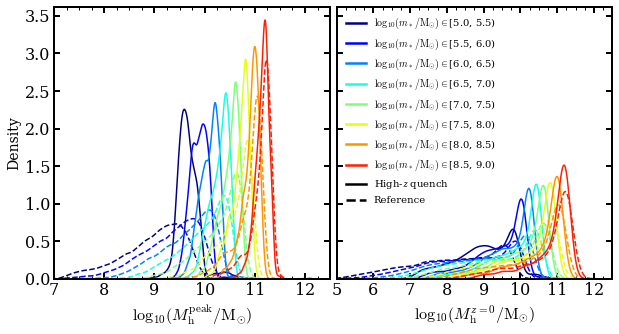

In [37]:
from scipy.stats import kde
def color(n, tot):
    return plt.cm.jet(n / tot, 1)

mbin = np.arange(5,9.5,0.5)
percentile=68 

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.025)
#ax[0].set_ylim([5,11.99])
#ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
#ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[0].set_ylabel('Density', size = 14)
ax[0].set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M^{z=0}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

#for i, axi in enumerate(ax.reshape(-1)):
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(7, 14.5+1, 0.25)))
ax[0].xaxis.set_ticks(np.arange(7,15))
ax[0].set_xlim([7,12.49])

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[1].xaxis.set_ticks(np.arange(4,15))
ax[1].set_xlim([5,12.49])

handles = []
models = [P60, P60_logistic]
ls = ['--', '-']
md = ['_peak', '']
for i in range(len(mbin)-1):
    txt = '$\in [{:.1f}, {:.1f})$ '.format(mbin[i], mbin[i+1])
    
    for j, m in enumerate(models):
        glist = m.galaxy.list(z=redshift, min_mstar=mbin[i], max_mstar=mbin[i+1])
        N = len(glist)
        of = (glist.Type==2).sum()/N
        txt += '& ${:d}$ & ${:.2f}$ '.format(N, of)
        for d, axi in enumerate(ax.reshape(-1)):
            sns.kdeplot(glist['Halo_mass'+md[d]].values, color=color(i, len(mbin)-1), ax=ax[d], ls=ls[j])

            k = kde.gaussian_kde(glist['Halo_mass'+md[d]].values)
            x = np.linspace(4,12,1000)
            y = k.evaluate(x)
            #peak, _ = find_peaks(y, height=0.5*y.max())
            peak = np.argmax(y)
            n=0
            mask = y > y[peak]*(0.95-n*0.01)
            while k.integrate_box_1d(x[mask][0], x[mask][-1]) < 0.68:
                n+=1
                mask = y > y[peak]*(0.98-n*0.01)

            q  = np.abs(x[mask][[0,-1]] - x[peak])

            s = '& ${0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}$ '
            txt += s.format(x[peak], q[0], q[1])

    label = '$\log_{10}(m_*/\mathrm{M}_{\odot}) \in$' + '[{:.1f}, {:.1f})'.format(mbin[i], mbin[i+1])
    handles += [Line2D([0], [0], color=color(i, len(mbin)-1), lw=2.5, ls='-', label=label)]
    txt += '\\\\'
    print(txt)

handles += [Line2D([0], [0], color='k', lw=2.5, ls='-', label='High-$z$ quench'),
            Line2D([0], [0], color='k', lw=2.5, ls='--', label='Reference')]
ax[1].legend(handles=handles, frameon=False)
P60.savefig('SHMR_scatter_joint.pdf', bbox_inches='tight')

In [166]:
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.stats import lognorm

In [323]:
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

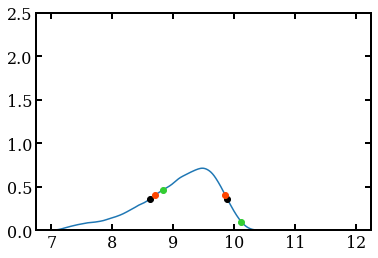

In [447]:
glist = P60.galaxy.list(z=0, min_mstar=5, max_mstar=6)
k = kde.gaussian_kde(glist['Halo_mass_peak'].values)
fig,ax = plt.subplots()
ax.set_ylim([0,2.5])
x = np.linspace(7,12,1000)
y = k.evaluate(x)
#peak, _ = find_peaks(y, height=0.5*y.max())
peak = np.argmax(y)

ax.plot(x,y)
mask = y > y[peak]*0.5
ax.plot(x[mask][[0,-1]], y[mask][[0,-1]], 'ko')

i=1
while integrate.simpson(y[peak-i:peak+i],x[peak-i:peak+i]) < 0.68:
    i+=1
ax.plot(x[[peak-i,peak+i]], y[[peak-i,peak+i]], 'o', color='limegreen')

i=0
mask = y > y[peak]*(0.95-i*0.01)
while integrate.simpson(y[mask],x[mask]) < 0.68:
    i+=1
    mask = y > y[peak]*(0.95-i*0.01)
    
ax.plot(x[mask][[0,-1]], y[mask][[0,-1]], 'o', color='orangered')

from scipy.stats import lognorm

popt, pcov = curve_fit(gaussian, x, y)
#ax.plot(x, gaussian(x,*popt), color='k', ls='--')
#lognorm.stats(*popt, moments='mvsk')
#stats.skew(y)

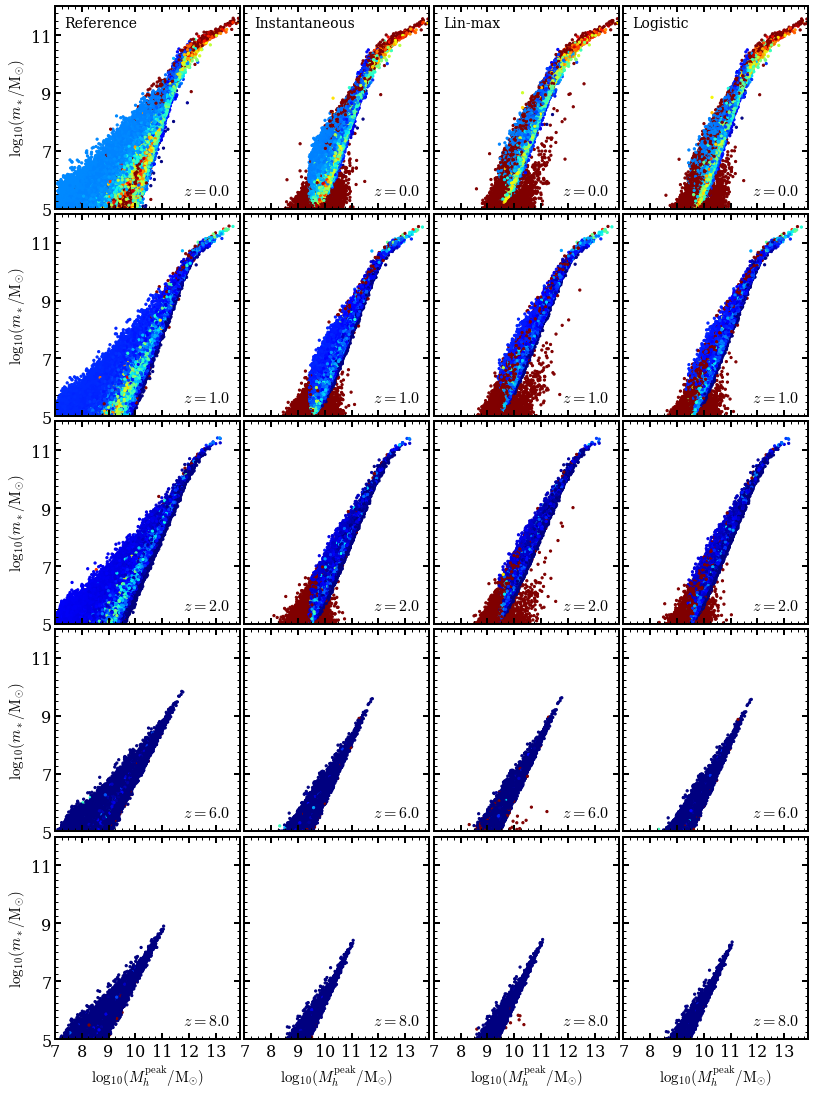

In [8]:
models = [P60, P60_inst, P60_linmax, P60_logistic]
xmin, xmax = 7, 13.9
frac = 1
vmin = -12.75
vmax = -8.9
peak = True
labelfs=15
if peak:
    p = '_peak'
else:
    p = ''
model_label = ['Reference', 'Instantaneous', 'Lin-max', 'Logistic']
redshifts = [0,1,2,6,8]
fig, ax = plt.subplots(5,4, figsize = (13.5,19), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.025, hspace=0.025)
ax[-1,0].set_xlim([xmin,xmax])
ax[-1,1].set_ylim([3,12])

for i in range(len(redshifts)):
    ax[i,0].set_ylim([5,12])
    ax[i,0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(3,12.75,2)))
    ax[i,0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(3,12.5,0.25)))
    ax[i,0].set_ylabel('$\log_{10}(m_* / \mathrm{M}_{\odot})$', size=labelfs)

for i in range(len(models)):
    ax[-1,i].set_xlim([xmin,xmax])
    ax[-1,i].xaxis.set_major_locator(ticker.FixedLocator(np.arange(xmin,14.75,1)))
    ax[-1,i].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(xmin,14.75,0.25)))
    if peak:
        ax[-1,i].set_xlabel('$\log_{10}(M_h^{\mathrm{peak}} / \mathrm{M}_{\odot})$', size=labelfs)
    else:
        ax[-1,i].set_xlabel('$\log_{10}(M_h / \mathrm{M}_{\odot})$', size=labelfs)

for i, m in enumerate(models[:4]):
    ax[0,i].annotate(model_label[i], xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top',color='k')
    for j, z in enumerate(redshifts):
        data = m.galaxy.list(min_mstar=5, redshift=z).sample(frac=frac)
        color = np.log10(data['SFR'] / (10**data['Stellar_mass']))
        color.loc[color == -np.inf] = vmin
        ln = ax[j,i].scatter(data['Halo_mass'+p], data['Stellar_mass'], s=5, c=color, cmap=plt.cm.jet_r, vmin=vmin, vmax=vmax, rasterized=True)
        ax[j,i].annotate('$z={:.1f}$'.format(z), xy=(1-0.05, 0.05), xycoords='axes fraction', size=16, ha='right', va='bottom',color='k')
fp = 'SHMR'+p+'_scatter.pdf'
#P60.savefig(fp, bbox_inches='tight')

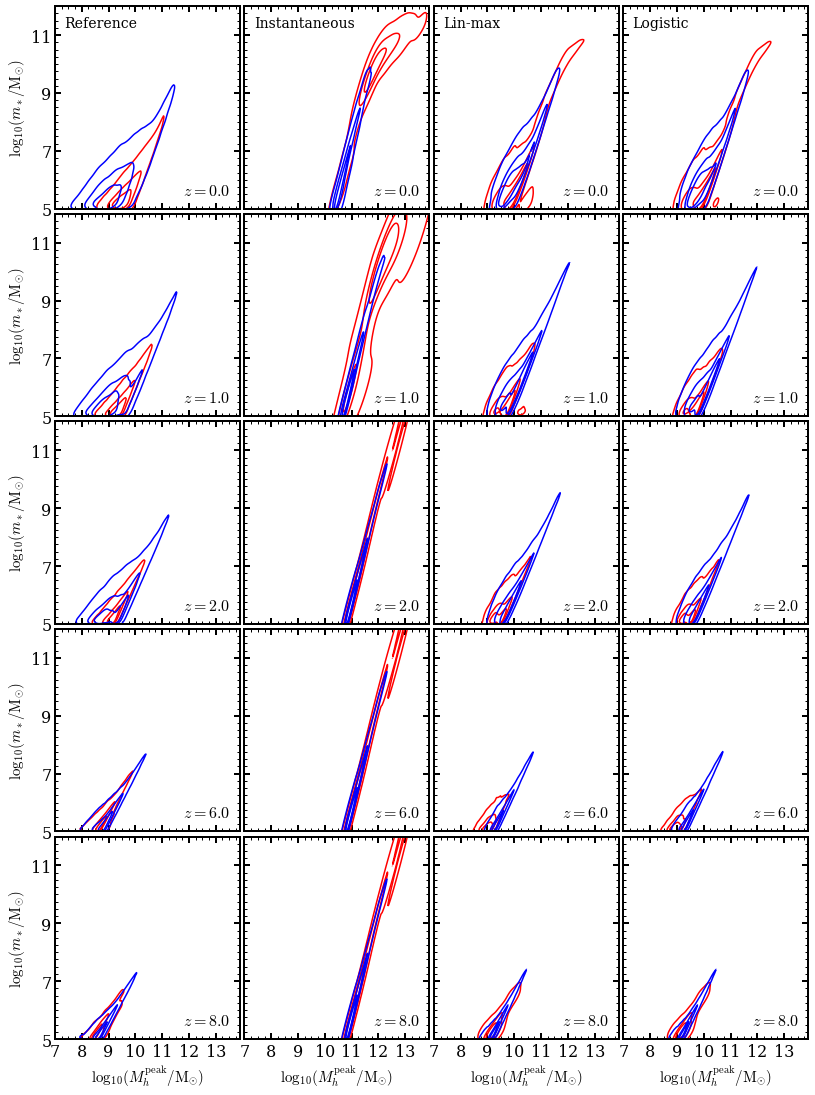

In [7]:
xmin, xmax = 7, 13.9
frac = 1
vmin = -12.75
vmax = -8.9
peak = True
labelfs=15
levels=4

if peak:
    p = '_peak'
else:
    p = ''

redshifts = [0,1,2,6,8]
fig, ax = plt.subplots(5,4, figsize = (13.5,19), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.025, hspace=0.025)
ax[-1,0].set_xlim([xmin,xmax])
ax[-1,1].set_ylim([3,12])

for i in range(len(redshifts)):
    ax[i,0].set_ylim([5,12])
    ax[i,0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(3,12.75,2)))
    ax[i,0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(3,12.5,0.25)))
    ax[i,0].set_ylabel('$\log_{10}(m_* / \mathrm{M}_{\odot})$', size=labelfs)

for i in range(len(models)):
    ax[-1,i].set_xlim([xmin,xmax])
    ax[-1,i].xaxis.set_major_locator(ticker.FixedLocator(np.arange(xmin,14.75,1)))
    ax[-1,i].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(xmin,14.75,0.25)))
    if peak:
        ax[-1,i].set_xlabel('$\log_{10}(M_h^{\mathrm{peak}} / \mathrm{M}_{\odot})$', size=labelfs)
    else:
        ax[-1,i].set_xlabel('$\log_{10}(M_h / \mathrm{M}_{\odot})$', size=labelfs)

for i, m in enumerate(models):
    ax[0,i].annotate(model_label[i], xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top',color='k')
    for j, z in enumerate(redshifts):
       # data = m.galaxy.list(min_mstar=5, min_mvir=xmin, redshift=z).sample(frac=frac)
       # sns.kdeplot(data=data, x="Halo_mass", y="Stellar_mass", ax=ax[j,i], color='black', levels=4)
        
        color = 'red'
        data = m.galaxy.list(min_mstar=5, min_mvir=xmin, redshift=z, color=color).sample(frac=frac)
        sns.kdeplot(data=data, x='Halo_mass'+p, y="Stellar_mass", ax=ax[j,i], color=color, levels=levels)
        
        color = 'blue'
        data = m.galaxy.list(min_mstar=5, min_mvir=xmin, redshift=z, color=color).sample(frac=frac)
        sns.kdeplot(data=data, x='Halo_mass'+p, y="Stellar_mass", ax=ax[j,i], color=color, levels=levels)
        ax[j,i].annotate('$z={:.1f}$'.format(z), xy=(1-0.05, 0.05), xycoords='axes fraction', size=16, ha='right', va='bottom',color='k')
fp = 'SHMR'+p+'_density.pdf'
P60.savefig(fp, bbox_inches='tight')

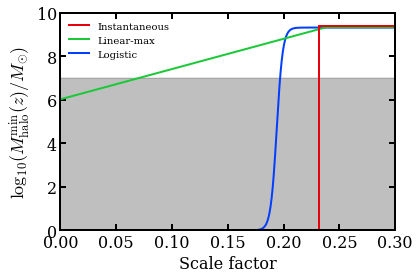

In [48]:
def logistic(x, x0=0.5, k=-1, L=1):
    return L / (1+np.exp(-(10**(k))*(x-x0)))
def linear(x, m=1, b=1):
    return m*x + b
def linear_max(x,m=1,ymax=1,xmax=1):
    m = 10**m
    x = np.atleast_1d(x)
    y = m*(x-xmax)+ymax
    mask = (y >= ymax)
    y[mask] = ymax
    return y

#x = np.linspace(0,1,1000)
x = np.linspace(0,1,1000)
miny, maxy = 0, 10
minx, maxx = 0, 0.3
fig, ax = plt.subplots()
ax.set_ylim([miny,maxy])
ax.set_xlim([minx,maxx])
ax.set_xlabel('Scale factor', size= 16)
ax.set_ylabel('$\log_{10}(M^{\mathrm{min}}_{\mathrm{halo}}(z)/M_{\odot})$', size=18)

xm, y, k = P60_logistic.params.get_param('Reionization_Scale'), P60_logistic.params.get_param('Reionization_Mass'), P60_logistic.params.get_param('Reionization_Rate')
#xm, y, k = 0.050880, 8.745994, 1.586910
ax.plot(x,logistic(x, x0=xm, k=k, L=y), color=sns.color_palette('bright')[0], lw=2)

xm, y, k = P60_linmax.params.get_param('Reionization_Scale'), P60_linmax.params.get_param('Reionization_Mass'), P60_linmax.params.get_param('Reionization_Rate')
#xm, y, k = 0.215, 9.2, 2.5
ax.plot(x,linear_max(x, m=k, ymax=y, xmax=xm), ls='-', color=sns.color_palette('bright')[2], lw=2)

xm, y = P60_inst.params.get_param('Reionization_Scale'), P60_inst.params.get_param('Reionization_Mass')
ax.axvline(x=xm, ymin=0, ymax=(y-miny)/(maxy-miny), color=sns.color_palette('bright')[3], lw=2)
ax.axhline(y=y, xmin=xm/(maxx-minx), xmax=1, color=sns.color_palette('bright')[3], lw=2)

ax.fill_between(x,np.zeros(len(x))+7, np.zeros(len(x)), alpha=0.25, color='k')

handles = [Line2D([0], [0], color=sns.color_palette('bright')[3], lw=2, ls='-', label='Instantaneous')]
#handles += [Line2D([0], [0], color='magenta', lw=2, ls='-', label='Linear')]
handles += [Line2D([0], [0], color=sns.color_palette('bright')[2], lw=2, ls='-', label='Linear-max')]
handles += [Line2D([0], [0], color=sns.color_palette('bright')[0], lw=2, ls='-', label='Logistic')]
ax.legend(handles=handles, frameon=False)
P60.savefig('mod_compare.pdf')
plt.show()

In [50]:
digby = pd.read_csv('../../Data/Catalogs/Digby2018.dat', sep = ' ', comment='#', index_col='GalaxyName')

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/Catalogs/Digby2018.dat'

In [89]:
Putman.loc[digby.index.values]

,RA,Dec,Velocity,Distance,LV,r_MW,r_M31,D_LG,StellarMass
GalaxyName,,,,,,,,,
AndromedaXXVIII,22h32m41s,"+31d12'58""",-326.0,661,210000.0,661,365,0,5.526339
Aquarius,20h46m52s,"-12d50'53""",-138.0,1072,1600000.0,1066,1170,740,6.408240
Cetus,00h26m11s,"-11d02'40""",-84.0,755,2800000.0,756,678,288,6.651278
IC1613,01h04m48s,"+02d07'04""",-232.0,755,100000000.0,758,518,172,8.204120
LeoA,09h59m26s,"+30d44'47""",24.0,798,6000000.0,803,1197,564,6.982271
LeoT,09h34m53s,"+17d03'05""",38.0,409,140000.0,414,982,187,5.350248
Phoenix,01h51m06s,"-44d26'41""",-13.0,415,770000.0,415,864,160,6.090611
Tucana,22h41m50s,"-64d25'10""",194.0,887,560000.0,883,1352,657,5.952308
AndromedaI,00h45m40s,"+38d02'28""",-376.0,745,4700000.0,749,55,−247,6.876218


In [99]:
dat[['t90_up', 't90_down']].values.astype(float).T

array([[0.67, 0.6 , 0.67, 0.87, 0.56, 2.01, 0.07, 2.5 , 0.2 , 9.77, 0.63,
        0.06, 0.6 , 9.36, 0.33, 3.53, 3.27],
       [0.84, 0.51, 1.47, 3.13, 0.49, 1.13, 1.49, 1.52, 0.27, 0.  , 1.03,
        0.2 , 0.75, 0.92, 1.82, 1.29, 1.6 ]])

In [544]:

def log_efficiency_new2(M, z, eps_N, eps_Nz, eps_Nm, alpha, alpha_z, beta, beta_z, M1, M1_z, MRI, MRI_z, gamma, gamma_z=0):
    eps_N = eps_N + eps_Nz * (z/(z+1))
    if eps_N > eps_Nm: eps_N = eps_Nm
    
    beta = beta + beta_z * (z/(z+1))
    gamma = gamma + gamma_z * (z/(z+1))
    M1 = M1 + M1_z * (z/(z+1))
    MRI = MRI + MRI_z  * (z/(z+1))
    
    alpha = alpha + alpha_z  * (z/(z+1))
    print(alpha)
    A = 1 + (10**(M-MRI))**(-alpha)
    
    return np.log10(2*eps_N)-np.log10(((10**(M-M1))**(-beta))*A + ((10**(M-M1))**gamma))

{'M1': 11.3228, 'M1_z': 1.44505, 'eps_N': 0.02035, 'eps_Nz': 1.69716, 'eps_Nm': 0.30385, 'beta': 2.98329, 'beta_z': -2.67877, 'gamma': 1.24905}
{'M1': 11.3228, 'M1_z': 1.44505, 'eps_N': 0.02035, 'eps_Nz': 1.69716, 'eps_Nm': 0.30385, 'beta': 2.8645, 'beta_z': -2.30471, 'gamma': 1.24905, 'MRI': 9.45446, 'MRI_z': 0.0724, 'alpha': 15, 'alpha_z': -16}
15.0
{'M1': 11.3228, 'M1_z': 1.44505, 'eps_N': 0.02035, 'eps_Nz': 1.69716, 'eps_Nm': 0.30385, 'beta': 2.98329, 'beta_z': -2.67877, 'gamma': 1.24905}
{'M1': 11.3228, 'M1_z': 1.44505, 'eps_N': 0.02035, 'eps_Nz': 1.69716, 'eps_Nm': 0.30385, 'beta': 2.8645, 'beta_z': -2.30471, 'gamma': 1.24905, 'MRI': 9.45446, 'MRI_z': 0.0724, 'alpha': 15, 'alpha_z': -16}
4.333333333333334
{'M1': 11.3228, 'M1_z': 1.44505, 'eps_N': 0.02035, 'eps_Nz': 1.69716, 'eps_Nm': 0.30385, 'beta': 2.98329, 'beta_z': -2.67877, 'gamma': 1.24905}
{'M1': 11.3228, 'M1_z': 1.44505, 'eps_N': 0.02035, 'eps_Nz': 1.69716, 'eps_Nm': 0.30385, 'beta': 2.8645, 'beta_z': -2.30471, 'gamma': 1

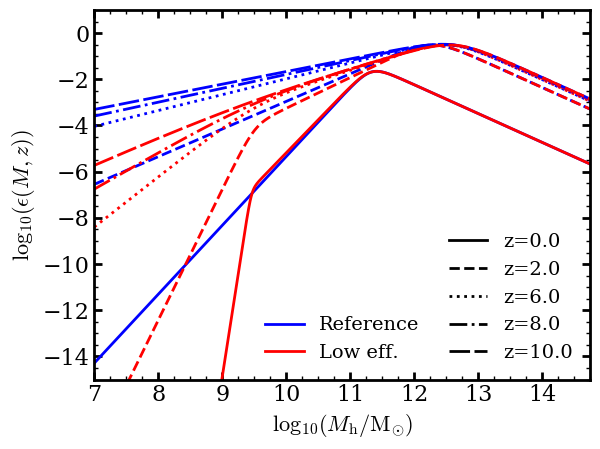

In [547]:


M = np.linspace(7,15,1000)
fig, ax = plt.subplots(1,1)
ax.set_ylim([-15,1])
ax.set_xlim([7,14.75])
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(7, 14.5+1, 0.25)))
ax.xaxis.set_ticks(np.arange(7,15))
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-19, 1, 0.5)))

ax.set_ylabel('$\log_{10}(\epsilon(M,z))$',size = 16)
ax.set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

redshift = [0,2,6,8,10]
lss = ['-', '--', ':','-.',ls('__')]

func = [log_efficiency, log_efficiency_new2]
models = [P30, P30_eff]
label = ['Reference', 'Low eff.']
color = ['b', 'r']
handles = []
handles2 = []
for i, z in enumerate(redshift):
    for j, m in enumerate(models):
        kwargs={}
        for key in alias.keys():
            try:
                kwargs[alias[key]]=float(m.params.get_param(key))
            except:
                pass
        if 'alpha_z' in kwargs.keys(): kwargs['alpha_z']=-16
        if 'alpha' in kwargs.keys(): kwargs['alpha']=15
        print(kwargs)
        ax.plot(M,func[j](M,z,**kwargs),color=color[j], ls=lss[i], lw=2)
        if i == 0:
            handles += [Line2D([0], [0], color=color[j], lw=2, ls='-', label=label[j])]
    handles2 += [Line2D([0], [0], color='k', lw=2, ls=lss[i], label='z={:.1f}'.format(z))]

leg1 = ax.legend(handles=handles, frameon=False, loc='lower center',fontsize=14)
leg2 = ax.legend(handles=handles2, frameon=False, loc='lower right',fontsize=14)
ax.add_artist(leg1)
#P30_eff.savefig(P30_eff.params.get_param('ModelName')+'_efficiency.pdf',bbox_inches='tight')
plt.show()

In [567]:
def log_efficiency_new2(M, z, eps_N, eps_Nz, eps_Nm, alpha, alpha_z, beta, beta_z, M1, M1_z, MRI, MRI_z, gamma, gamma_z=0):
    eps_N = eps_N + eps_Nz * (z/(z+1))
    if eps_N > eps_Nm: eps_N = eps_Nm
    
    beta = beta + beta_z * (z/(z+1))
    gamma = gamma + gamma_z * (z/(z+1))
    M1 = M1 + M1_z * (z/(z+1))
    MRI = MRI + MRI_z  * (z/(z+1))
    
    alpha = alpha + alpha_z  * (z/(z+1))
    #print(alpha)
    A = (10**(M-MRI))**(-alpha)
    
    return np.log10(2*eps_N)-np.log10(((10**(M-M1))**(-beta))+A + ((10**(M-M1))**gamma))

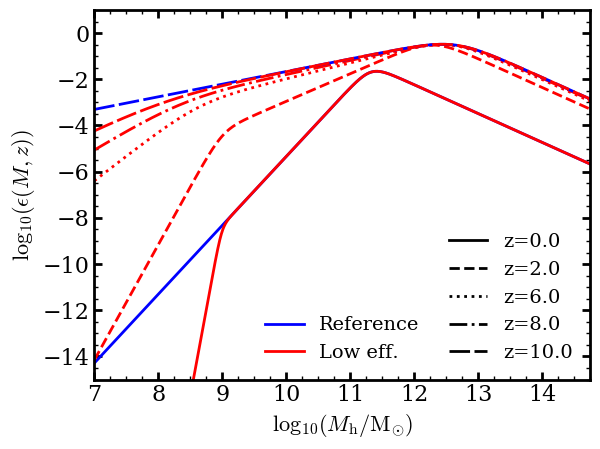

In [581]:
kwargs_A = {'M1': 11.3228, 'M1_z': 1.44505, 'eps_N': 0.02035, 'eps_Nz': 1.69716, 'eps_Nm': 0.30385, 'beta': 2.98329, 'beta_z': -2.67877, 'gamma': 1.24905}
kwargs_B = {'M1': 11.3228, 'M1_z': 1.44505, 'eps_N': 0.02035, 'eps_Nz': 1.69716, 'eps_Nm': 0.30385, 'beta': 2.98329, 'beta_z': -2.67877, 'gamma': 1.24905, 'MRI': 9.45446, 'MRI_z': 0.5, 'alpha': 15, 'alpha_z': -15}
func = [log_efficiency, log_efficiency_new2]


M = np.linspace(7,15,1000)
fig, ax = plt.subplots(1,1)
ax.set_ylim([-15,1])
ax.set_xlim([7,14.75])
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(7, 14.5+1, 0.25)))
ax.xaxis.set_ticks(np.arange(7,15))
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-19, 1, 0.5)))

ax.set_ylabel('$\log_{10}(\epsilon(M,z))$',size = 16)
ax.set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

z=0
ax.plot(M,func[0](M,z,**kwargs_A),color=color[0], ls=lss[0], lw=2)
ax.plot(M,func[1](M,z,**kwargs_B),color=color[1], ls=lss[0], lw=2)

z=2
ax.plot(M,func[1](M,z,**kwargs_B),color=color[1], ls=lss[1], lw=2)
z=6
ax.plot(M,func[1](M,z,**kwargs_B),color=color[1], ls=lss[2], lw=2)

z=8
ax.plot(M,func[1](M,z,**kwargs_B),color=color[1], ls=lss[3], lw=2)

z=10
ax.plot(M,func[0](M,z,**kwargs_A),color=color[0], ls=lss[4], lw=2)
ax.plot(M,func[1](M,z,**kwargs_B),color=color[1], ls=lss[4], lw=2)

handles = [Line2D([0], [0], color=color[0], lw=2, ls='-', label=label[0])]
handles += [Line2D([0], [0], color=color[1], lw=2, ls='-', label=label[1])]
leg1 = ax.legend(handles=handles, frameon=False, loc='lower center',fontsize=14)
leg2 = ax.legend(handles=handles2, frameon=False, loc='lower right',fontsize=14)
ax.add_artist(leg1)
plt.show()

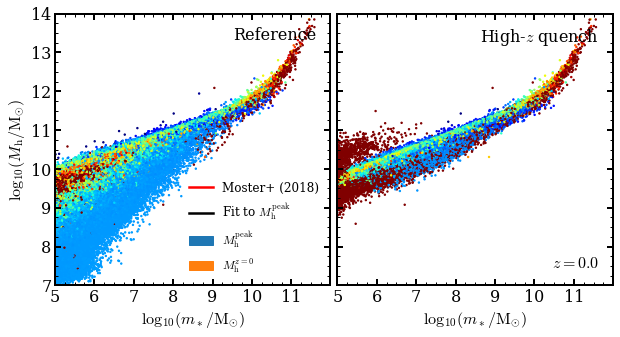

In [62]:
vmin = -12.75
vmax = -8.9

model = P60_logistic
def double_power(x, a, b, c, d):
    return x+b-np.log10((10.**(x-a))**(-c)+(10.**(x-a))**(d))

def tripple_power(x, a, b, c, d, e, f):
    return x+b-np.log10((10.**(x-f))**(-e) (10.**(x-a))**(-c)+(10.**(x-a))**(d))

# setup the data
vmin, vmax = -12.5, -8.9 
mh_min, mh_max, bin_size = 10, 13.7, 0.2
redshift=0
galaxies = model.galaxy.list(z=redshift, min_mstar=5) # select only type 0 galaxies
f_baryon = model.cosmology.Ob0 / model.cosmology.Om0

mbin=np.arange(mh_min,mh_max,bin_size)

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_xlim([5,11.99])
ax[1].set_xlim([5,11.99])
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[0].set_xlabel('$\log_{10}(m_*/\mathrm{M}_{\odot})$',size = 16)
ax[1].set_xlabel('$\log_{10}(m_*/\mathrm{M}_{\odot})$',size = 16)
ax[0].set_ylabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
#ax[1].set_ylabel('$\log_{10}(M^{z=0}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[0].set_ylabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
#ax[1].set_ylabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

#for i, axi in enumerate(ax.reshape(-1)):
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[0].yaxis.set_ticks(np.arange(4,15))
ax[0].set_ylim([7,14])

ax[1].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[1].yaxis.set_ticks(np.arange(4,15))
ax[1].set_ylim([7,14])


# Reference model
glist = P60.galaxy.list(z=redshift, min_mstar=5)
#sns.kdeplot(data=glist, y='Halo_mass_peak', x="Stellar_mass", ax=ax[0], levels=6, fill=True)

color = np.log10(glist['SFR'] / (10**glist['Stellar_mass']))
color.loc[color == -np.inf] = vmin
ax[0].scatter(glist['Stellar_mass'], glist['Halo_mass_peak'], s=2, c=color, cmap=plt.cm.jet_r, vmin=vmin, vmax=vmax, rasterized=True)
ax[0].annotate('Reference', xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=16, ha='right', va='top',color='k')


# logistic
glist = P60_logistic.galaxy.list(z=redshift, min_mstar=5)
#sns.kdeplot(data=glist, y='Halo_mass_peak', x="Stellar_mass", ax=ax[1], levels=6, fill=True)
color = np.log10(glist['SFR'] / (10**glist['Stellar_mass']))
color.loc[color == -np.inf] = vmin
ax[1].scatter(glist['Stellar_mass'], glist['Halo_mass_peak'], s=2, c=color, cmap=plt.cm.jet_r, vmin=vmin, vmax=vmax, rasterized=True)
ax[1].annotate('High-$z$ quench', xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=16, ha='right', va='top',color='k')


ax[1].annotate('$z={:.1f}$'.format(redshift), xy=(1-0.05, 0.05), xycoords='axes fraction', size=16, ha='right', va='bottom')

handles = [Line2D([0], [0], color='r', lw=2.5, ls='-', label='Moster+ (2018)'),
           Line2D([0], [0], color='k', lw=2.5, ls='-', label='Fit to $M^{\mathrm{peak}}_{\mathrm{h}}$'),
           patches.Patch(color=sns.color_palette()[0], label='$M^{\mathrm{peak}}_{\mathrm{h}}$'),
           patches.Patch(color=sns.color_palette()[1], label='$M^{z=0}_{\mathrm{h}}$') ]
ax[0].legend(handles=handles, frameon=False, fontsize=12)

Text(0.05, 0.95, 'Satellites')

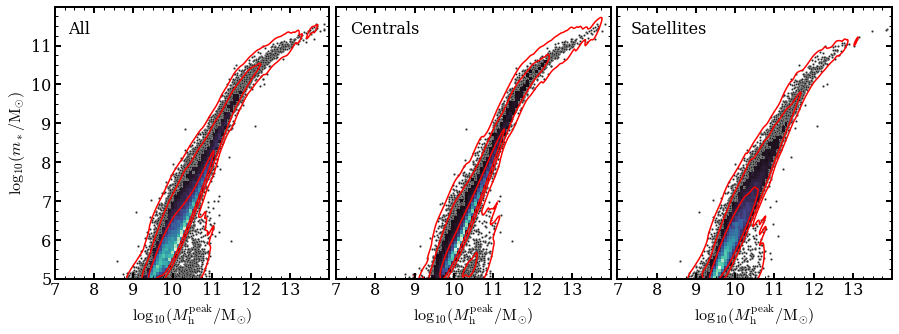

In [82]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_ylim([5,11.99])
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[0].set_ylabel('$\log_{10}(m_*/\mathrm{M}_{\odot})$',size = 16)
ax[0].set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M^{z=0}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[0].set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

for i, axi in enumerate(ax.reshape(-1)):
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
    axi.xaxis.set_ticks(np.arange(4,15))
    axi.set_xlim([7,13.99])
    axi.set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

a = 0
glist = P60_logistic.galaxy.list(z=redshift, min_mstar=5)
#sns.kdeplot(data=glist, y='Halo_mass_peak', x="Stellar_mass", ax=ax[0], levels=6, fill=True)
sns.scatterplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", s=5, color=".15", rasterized=True,ax=ax[a])
sns.histplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", bins=75, pthresh=.1, cmap="mako", ax=ax[a])
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[a], levels=1-np.array([0.997, 0.95, 0.68]), color='red')
ax[a].annotate('All', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top',color='k')

a = 1
glist = P60_logistic.galaxy.list(z=redshift, min_mstar=5, gtype=0)
#sns.kdeplot(data=glist, y='Halo_mass_peak', x="Stellar_mass", ax=ax[0], levels=6, fill=True)
sns.scatterplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", s=5, color=".15", rasterized=True,ax=ax[a])
sns.histplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", bins=75, pthresh=.1, cmap="mako", ax=ax[a])
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[a], levels=1-np.array([0.997, 0.95, 0.68]), color='red')
ax[a].annotate('Centrals', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top',color='k')

a = 2
glist = P60_logistic.galaxy.list(z=redshift, min_mstar=5, gtype=[1,2])
#sns.kdeplot(data=glist, y='Halo_mass_peak', x="Stellar_mass", ax=ax[0], levels=6, fill=True)
sns.scatterplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", s=5, color=".15", rasterized=True,ax=ax[a])
sns.histplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", bins=75, pthresh=.1, cmap="mako", ax=ax[a])
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[a], levels=1-np.array([0.997, 0.95, 0.68]), color='red')
ax[a].annotate('Satellites', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top',color='k')


In [93]:
P60_logistic.galaxy.list(min_mvir=14).Stellar_mass

ID
570703819    11.458258
630365524    11.713143
662881315    11.616196
Name: Stellar_mass, dtype: float32

In [ ]:
model_label = ['High-$z$ quench', 'Reference']
model_color = ['blue', 'green']
model_color = sns.color_palette('bright')
ls = ['-', '--', ':']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]
models = [P60_logistic, P60]
mvir_range = [(np.log10(1e12), np.log10(2e12)),
              (np.log10(1.4e12), np.log10(5e12))]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_yscale('log')
ax[0].set_ylim([1,150])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax[0].set_ylabel('$N_{\mathrm{sat}}(>\log_{10}(m_*/M_{\odot}))$',size=16)


bins = np.histogram_bin_edges([5,9],bins=7)
hist, edges = np.histogram(MW_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[0].plot(mid, N, lw=3, color='black', label='Milky Way', alpha=0.5)
ax[0].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)

hist, edges = np.histogram(M31_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[1].plot(mid, N, lw=3, color='black', label='Andromeda', alpha=0.5)
ax[1].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)

cases = [((10.6, 10.78, 0, np.inf),
         (5, np.inf, 12.0, 12.2),
         (10.6, 10.78, 12.0, 12.2)),
         ((10.93, 11.1, 0, np.inf),
         (5, np.inf, 12.15, 12.3),
         (10.93, 11.1, 12.15, 12.3))]

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    min_mvir, max_mvir = mvir_range[i]
    axi.set_xlabel('$\log_{10}(m_*^{\mathrm{sat}}/M_{\odot})$', size=16)
    axi.set_xlim([4.9,9.1])
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,10,0.25)))
    #full_label = '${:.1f}'.format(min_mstar)+'\leq \log_{10}(m^{\mathrm{host}}_*/M_{\odot})<'+'{:.1f}$'.format(max_mstar)
    #axi.annotate(full_label, xy=(0.5, 1-0.02), xycoords='axes fraction', size=14, ha='center', va='top')
    case = cases[i]
    for j, m in enumerate(models):
        for k, c in enumerate(case): 
            min_mstar, max_mstar, min_mvir, max_mvir = c
            hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0, min_mvir=min_mvir, max_mvir=max_mvir)
            Ntot = np.zeros(len(edges)-1)
            for index, row in hosts.iterrows():
                sats = m.galaxy.list(ihost=index, min_mstar=5)

                hist, _ = np.histogram(sats['Stellar_mass'].values, bins=bins)
                N = hist[::-1].cumsum()[::-1]
                #mid = (edges[1:] + edges[:-1])/2
                Ntot += N
            axi.plot(mid, Ntot/len(hosts), lw=2, color=model_color[j], ls=ls[k])
    
    #axi.legend(frameon=False, loc='lower left')
    
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Milky Way', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls=':', label='$m_*$ and $M_{\\mathrm{h}}$ selected')]
ax[0].legend(handles=handles, loc='upper right', frameon=False)

handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Andromeda', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected')]
ax[1].legend(handles=handles, loc='upper right', frameon=False)
ax[0].annotate('Milky Way', xy=(0.05, 0.05), xycoords='axes fraction', size=14, ha='left', va='bottom')
ax[1].annotate('Andromeda', xy=(0.05, 0.05), xycoords='axes fraction', size=14, ha='left', va='bottom')
#P60.savefig('cumulative_sat_smf.pdf', bbox_inches='tight')
plt.show()

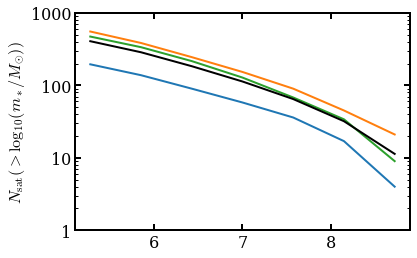

In [98]:
fig, ax = plt.subplots()

ax.set_yscale('log')
ax.set_ylim([1,1000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.set_ylabel('$N_{\mathrm{sat}}(>\log_{10}(m_*/M_{\odot}))$',size=16)

bins = np.histogram_bin_edges([5,9],bins=7)
hist, edges = np.histogram(MW_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2

min_mstar, max_mstar = 0, np.inf
hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0, z=0, min_mvir=14, max_mvir=np.inf)
Ntot = np.zeros(len(edges)-1)
for index, row in hosts.iterrows():
    sats = m.galaxy.list(ihost=index, min_mstar=5)

    hist, _ = np.histogram(sats['Stellar_mass'].values, bins=bins)
    N = hist[::-1].cumsum()[::-1]
    #mid = (edges[1:] + edges[:-1])/2
    Ntot += N
    ax.plot(mid, N, lw=2)
ax.plot(mid, Ntot/len(hosts), lw=2, color='k')

In [129]:
z = 0
1/np.sqrt(1+3*c.Ob(z)/c.Ogamma(z)/4)

0.03844875023809879

In [115]:
P60.cosmology.Ogamma0

0.0

In [121]:
c =          apcos.LambdaCDM(H0=0.6781 * 100,
                                        Om0=0.308,
                                        Ode0=0.692,
                                        Ob0=0.0484,
                            Tcmb0 = 2.725) 

In [122]:
c.Ogamma(1)

5.374196923062941e-05

0.5773502691896258

In [133]:
from astropy import constants as const

In [143]:
const.c.to('kpc/yr')*c.age(1100).to('yr')/np.sqrt(3)

<Quantity 64.92423588 kpc>

In [138]:
c.age(1100).to('yr')

<Quantity 366769.61509798 yr>

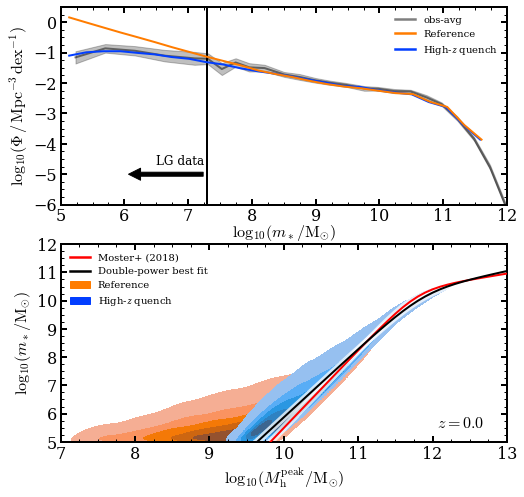

In [43]:
def double_power(x, a, b, c, d):
    return x+b-np.log10((10.**(x-a))**(-c)+(10.**(x-a))**(d))
obs = np.array([[5.233, -1.1578, -0.9564, -1.3593, 1],
                [5.700, -0.8612, -0.7205, -1.0019, 1],
                [6.167, -0.9412, -0.7873, -1.0952, 10],
                [6.633, -1.1015, -0.9127, -1.2904, 1],
                [7.100, -1.1898, -0.9778, -1.4017, 1],
                [7.308, -1.2024, -1.0244, -1.3805, 1],
                [7.528, -1.5414, -1.3445, -1.7383, 1],
                [7.744, -1.3254, -1.1874, -1.4635, 1],
                [7.958, -1.4859, -1.3490, -1.6228, 1],
                [8.198, -1.5099, -1.4009, -1.6189, 10],
                [8.506, -1.7191, -1.6391, -1.7992, 1],
                [8.748, -1.8023, -1.7063, -1.8983, 1],
                [8.995, -1.9130, -1.8358, -1.9902, 1],
                [9.225, -1.9922, -1.9237, -2.0607, 1],
                [9.484, -2.0655, -2.0021, -2.1290, 10],
                [9.759, -2.1779, -2.1006, -2.2552, 1],
                [9.976, -2.1896, -2.1298, -2.2493, 1],
                [10.234, -2.2667, -2.1983, -2.3351, 1],
                [10.489, -2.2796, -2.2242, -2.3351, 1],
                [10.739, -2.4748, -2.4006, -2.5489, 1],
                [10.975, -2.6970, -2.6399, -2.7541, 10],
                [11.220, -3.1690, -3.0981, -3.2400, 10],
                [11.483, -3.8379, -3.7763, -3.8995, 1],
                [11.733, -4.7683, -4.6912, -4.8453, 10],
                [11.983, -6.0591, -5.9778, -6.1404, 1],
                [12.183, -7.1393, -6.8773, -7.4012, 1]])



fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,8))
model_label = [ 'High-$z$ quench', 'Reference']
model_color = sns.color_palette('bright')


ax[0].set_xlabel('$\log_{10}(m_* / \mathrm{M}_{\odot})$', size=16,labelpad=-2.5)
ax[0].set_ylabel('$\log_{10}(\Phi \, / \, \mathrm{Mpc}^{-3}\,\mathrm{dex}^{-1})$', size=16)
ax[0].set_xlim([5,12])
ax[0].set_ylim([-6,0.5])
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.arange(5,13,1)))
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,13,0.25)))
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-6,1,0.25)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(-6, 1, 1)))

galaxies = P60_logistic.galaxy.list(min_mstar=5)
Lbox = P60_logistic.params.get_param('BoxSize') / P60.cosmology.h
ln = plot_smf(galaxies['Stellar_mass'].values,Lbox=Lbox,ax=ax[0], lw=2,zorder=10, color = model_color[0], bins=25)

galaxies = P60.galaxy.list(min_mstar=5)
Lbox = P60.params.get_param('BoxSize') / P60.cosmology.h
ln = plot_smf(galaxies['Stellar_mass'].values,Lbox=Lbox,ax=ax[0], lw=2,zorder=10, color = model_color[1], bins=25)


ax[0].plot(obs[:,0],obs[:,1], label='obs-avg', lw = 2, color = 'black', alpha=0.5)
ax[0].fill_between(obs[:,0], obs[:,2], obs[:,3], color='black', alpha=0.25,zorder=0)
ax[0].axvline(x=7.3, ymin=-7, ymax=1, color='black', lw=2)
ax[0].annotate('', xy=(6, -5),  xycoords='data',
            xytext=(7.3, -5), textcoords='data',
            arrowprops=dict(facecolor='black', edgecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom',
            )
ax[0].annotate('LG data', xy=(7.25, -4.8), xycoords='data', size=12, ha='right', va='bottom')

handles = [Line2D([0], [0], color='k', lw=2.5, alpha=0.5, label='obs-avg'),
           Line2D([0], [0], color=model_color[1], lw=2.5, label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, label='High-$z$ quench')]
ax[0].legend(handles = handles, frameon=False)


ax[1].annotate('$z={:.1f}$'.format(0), xy=(1-0.05, 0.05), xycoords='axes fraction', size=16, ha='right', va='bottom')
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(7, 14.5+1, 0.25)))
ax[1].xaxis.set_ticks(np.arange(7,15))
ax[1].set_xlim([7,13])
ax[1].set_ylim([5,12])
ax[1].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax[1].yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))

f_baryon = P60.cosmology.Ob0 / P60.cosmology.Om0

# moster 2018
x = np.arange(9,15,0.1)
old = np.array([11.80, 0.14, 1.75, 0.57])
ax[1].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='r',lw=2,zorder=10, label='Moster+ (2018)')
ax[1].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='white',lw=7,alpha=0.75)

glist = P60_logistic.galaxy.list(z=0, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[1], levels=6, fill=True)
mh_min, mh_max, bin_size = 10, 13.7, 0.2
mbin=np.arange(mh_min,mh_max,bin_size)
mhalo,_,_ = binned_statistic(glist['Halo_mass_peak'], glist['Halo_mass_peak'], statistic='mean',bins=mbin)
mstar,_,_= binned_statistic(glist['Halo_mass_peak'], glist['Stellar_mass'], statistic='mean',bins=mbin)
popt, pcov = curve_fit(double_power, mhalo, mstar,p0=[10,1,1,1],maxfev=10000)
ax[1].plot(x,double_power(x,*popt),color='black',lw=2,zorder=10)
ax[1].plot(x,double_power(x,*popt),color='white',lw=7,alpha=0.75)

glist = P60.galaxy.list(z=0, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[1], levels=6, fill=True, zorder=0)


handles = [Line2D([0], [0], color='r', lw=2.5, ls='-', label='Moster+ (2018)'),
           Line2D([0], [0], color='k', lw=2.5, ls='-', label='Double-power best fit'),
           patches.Patch(color=sns.color_palette('bright')[1], label='Reference'),
           patches.Patch(color=sns.color_palette('bright')[0], label='High-$z$ quench')]
ax[1].legend(handles=handles, frameon=False)

ax[1].set_ylabel('$\log_{10}(m_*/\mathrm{M}_{\odot})$',size = 16)
ax[1].set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

plt.savefig('./SHMR_application.pdf', bbox_inches='tight')

plt.show()

In [ ]:
obs = np.array([[5.233, -1.1578, -0.9564, -1.3593, 1],
                [5.700, -0.8612, -0.7205, -1.0019, 1],
                [6.167, -0.9412, -0.7873, -1.0952, 10],
                [6.633, -1.1015, -0.9127, -1.2904, 1],
                [7.100, -1.1898, -0.9778, -1.4017, 1],
                [7.308, -1.2024, -1.0244, -1.3805, 1],
                [7.528, -1.5414, -1.3445, -1.7383, 1],
                [7.744, -1.3254, -1.1874, -1.4635, 1],
                [7.958, -1.4859, -1.3490, -1.6228, 1],
                [8.198, -1.5099, -1.4009, -1.6189, 10],
                [8.506, -1.7191, -1.6391, -1.7992, 1],
                [8.748, -1.8023, -1.7063, -1.8983, 1],
                [8.995, -1.9130, -1.8358, -1.9902, 1],
                [9.225, -1.9922, -1.9237, -2.0607, 1],
                [9.484, -2.0655, -2.0021, -2.1290, 10],
                [9.759, -2.1779, -2.1006, -2.2552, 1],
                [9.976, -2.1896, -2.1298, -2.2493, 1],
                [10.234, -2.2667, -2.1983, -2.3351, 1],
                [10.489, -2.2796, -2.2242, -2.3351, 1],
                [10.739, -2.4748, -2.4006, -2.5489, 1],
                [10.975, -2.6970, -2.6399, -2.7541, 10],
                [11.220, -3.1690, -3.0981, -3.2400, 10],
                [11.483, -3.8379, -3.7763, -3.8995, 1],
                [11.733, -4.7683, -4.6912, -4.8453, 10],
                [11.983, -6.0591, -5.9778, -6.1404, 1],
                [12.183, -7.1393, -6.8773, -7.4012, 1]])

fig,ax = plt.subplots()
ax.set_xlabel('$\log_{10}(m_* / \mathrm{M}_{\odot})$', size=16)
ax.set_ylabel('$\log_{10}(\Phi \, / \, \mathrm{Mpc}^{-3}\,\mathrm{dex}^{-1})$', size=16)
ax.set_xlim([5,12])
ax.set_ylim([-6,0.5])
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(5,13,1)))
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,13,0.25)))
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-6,1,0.25)))
data = []

model_label = [ 'Logistic', 'Reference', 'Instantaneous', 'Lin-max']
model_color = sns.color_palette('bright')
models = [P60_logistic, P60, P60_inst, P60_linmax, ]
for i, m in enumerate(models):
    print(m.params.get_param('ModelName'))
    galaxies = m.galaxy.list(min_mstar=5)
    Lbox = m.params.get_param('BoxSize') / m.cosmology.h
    ln = plot_smf(galaxies['Stellar_mass'].values,Lbox=Lbox,ax=ax, color=model_color[i], lw=2, label=model_label[i],zorder=10, bins=25)
    
    vol=Lbox**3
    galaxies = m.galaxy.list(min_mstar=5)
    N, edges = np.histogram(galaxies['Stellar_mass'].values, bins=25)
    smf_x = (edges[:-1] + edges[1:]) / 2
    db = (edges[1] - edges[0])
    smf_y = np.log10(N/db/vol)
    
    

    mask = (smf_x > 6.0) & (smf_x <= 7.0) 
    popt, pcov = curve_fit(line, smf_x[mask], smf_y[mask])
    print('Global slope: {:.2f}'.format(popt[0]))

    
    hosts = m.galaxy.list(min_mstar=10.5, max_mstar=10.8, z=0, gtype=0)
    slope = np.zeros(len(hosts))
    offset = np.zeros(len(hosts))
    j=0
    c = ['blue']*len(hosts)
    mod = [model_label[i]]*len(hosts)
    for index, row in hosts.iterrows():
        x,y,z = row[['X_pos','Y_pos','Z_pos']].values
        
        LG = m.galaxy.list(min_mstar=5, max_mstar=7)
        pos = LG[['X_pos','Y_pos','Z_pos']].values
        xs, ys, zs = pos[:,0], pos[:,1], pos[:,2]
        xc, yc, zc = [x]*len(pos), [y]*len(pos), [z]*len(pos)
        r_sat = radial_distance(xs, ys, zs, xc, yc, zc, period=m.params.get_param('BoxSize')/m.cosmology.h)
        LG = LG.loc[r_sat<2]
        
        M31 = m.galaxy.list(min_mstar=10.8, max_mstar=11.2)
        pos = M31[['X_pos','Y_pos','Z_pos']].values
        xa, ya, za = pos[:,0], pos[:,1], pos[:,2]
        xc, yc, zc = [x]*len(pos), [y]*len(pos), [z]*len(pos)
        r_m31 = radial_distance(xa, ya, za, xc, yc, zc, period=m.params.get_param('BoxSize')/m.cosmology.h)
        #if np.any(r_m31<1): c[j] = 'red'
        if (r_m31<1).sum()==1: c[j] = 'red'
        
        
        #ln = plot_smf(LG['Stellar_mass'].values, Lbox=2, geo='sphere', ax=ax, color='k', lw=2, zorder=10, bins=10, alpha=0.1)
        
        vol = 4*np.pi*(2**3)/3
        N, edges = np.histogram(LG['Stellar_mass'].values, bins=10)
        centers = (edges[:-1] + edges[1:]) / 2
        db = (edges[1] - edges[0])
        y = np.log10(N/db/vol)
        ymask = y>-np.inf

        if ymask.sum() < 2:
            continue
        popt, pcov = curve_fit(line, centers[y>-np.inf], y[y>-np.inf])
        slope[j] = popt[0]
        
        def smf_fun(mass, alpha):
            func = interp1d(centers[y>-np.inf], y[y>-np.inf], fill_value='extrapolate')
            return func(mass) - alpha
        popt, pcov = curve_fit(smf_fun, smf_x[mask], smf_y[mask], p0=[1])
        offset[j] = popt[0]

        j+=1
    temp = pd.DataFrame(columns=['slope', 'offset', 'color', 'model'])
    temp['slope'] = slope
    temp['offset'] = offset
    temp['color'] = c
    temp['model'] = mod
    data += [temp]

    print("Average slope: {:.2f}+-{:.2f}".format(slope.mean(), slope.std()))
    print("Average offset: {:.2f}+-{:.2f}\n".format(offset.mean(), offset.std()))

ax.plot(obs[:,0],obs[:,1], label='obs-avg', lw = 2, color = 'black', alpha=0.5)
ax.fill_between(obs[:,0], obs[:,2], obs[:,3], color='black', alpha=0.25,zorder=0)

color = sns.color_palette('bright')
handles = [Line2D([0], [0], color='k', lw=2.5, alpha=0.5, label='obs-avg'),
           Line2D([0], [0], color=color[1], lw=2.5, label='Reference'),
           Line2D([0], [0], color=color[2], lw=2.5, label='Instantaneous'),
           Line2D([0], [0], color=color[3], lw=2.5, label='Lin-max'),
           Line2D([0], [0], color=color[0], lw=2.5, label='Logistic')]
ax.legend(handles = handles, frameon=False)
ax.axvline(x=7.3, ymin=-7, ymax=1, color='black', lw=2)
ax.annotate('', xy=(6, -5),  xycoords='data',
            xytext=(7.3, -5), textcoords='data',
            arrowprops=dict(facecolor='black', edgecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom',
            )
ax.annotate('LG data', xy=(7.25, -4.8), xycoords='data', size=12, ha='right', va='bottom')
#P60.savefig('global_smf.pdf', bbox_inches='tight')
plt.show()
data = pd.concat(data)